# Construction Cash Flow Optimization

### Importing Packages

In [1]:
import logging
import pickle
import copy
import numpy as np
import matplotlib.pyplot as plt

### Configuration

In [2]:
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s]%(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["figure.dpi"] = 120

### Initiate a project

In [3]:
class Project: pass  # Create a blank class
project = Project()  # Initiate a blank project object
project.start = np.datetime64("2019-01-01")
project.number_of_activities = 5
project.dur = np.zeros(project.number_of_activities)  # duration

### Randomize the project

In [4]:
# Randomize the durations, costs, and preds
project.dur = np.array([np.timedelta64(np.random.randint(5, 30), 'D') for i in range(project.number_of_activities)])
project.cost = np.random.randint(5, 20, size=(project.number_of_activities))
project.pred = [
    [i - np.random.randint(1, i), ] if i > 1 else [] 
    for i in range(project.number_of_activities)
]

### Financial Parameters for the project

In [5]:
project.downpayment = 0.15
project.retention = 0.1
project.payment_days = 28
project.markup = 0.05
project.interest = 0.10

## Calculate the project

In [6]:
# Initiate ES and EF
project.es = np.array([project.start for i in range(project.number_of_activities)])
project.ef = project.es + project.dur
# Perform Front Run
logging.info("Starting the Front Run...")
cond = True
while cond:
    cond = False
    for i in range(project.number_of_activities):
        for pred in project.pred[i]:
            if project.es[i] < project.ef[pred]:
                project.es[i] = project.ef[pred]
                project.ef[i] = project.es[i] + project.dur[i]
                cond = True
del cond
# Record the project finish
project.finish = project.ef.max()
# Perform the Back Run
logging.info("Starting the Back Run...")
# Intiate the LS and LF
project.lf = np.array([project.finish for i in range(project.number_of_activities)])
project.ls = project.lf - project.dur
cond = True
while cond:
    cond = False
    for i in range(project.number_of_activities):
        for pred in project.pred[i]:
            if project.lf[pred] > project.ls[i]:
                project.lf[pred] = project.ls[i]
                project.ls[pred] = project.lf[pred] - project.dur[pred]
                cond = True
del cond
# Calculate the TF
project.tf = project.ls - project.es
logging.info("Done!")

[22:59:56]INFO: Starting the Front Run...
[22:59:56]INFO: Starting the Back Run...
[22:59:56]INFO: Done!


## Plot the Calculated Schedule

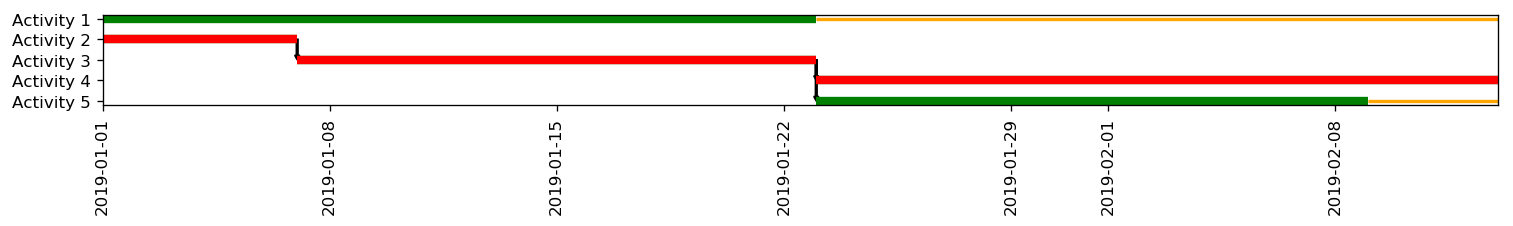

In [7]:
plt.figure(figsize=(15, int(project.number_of_activities / 3)))
# Draw Activities
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=project.es,
    xmax=project.ef,
    linewidth=5,
    color="green"
)
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=np.array([project.es[i] if project.es[i] == project.ls[i] else project.es[i] for i in range(project.number_of_activities)]),
    xmax=np.array([project.ef[i] if project.es[i] == project.ls[i] else project.es[i] for i in range(project.number_of_activities)]),
    linewidth=5,
    color="red"
)
# Draw Late
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=project.ef,
    xmax=project.lf,
    linewidth=2,
    color="orange"
)
# Draw Arrow
for i in range(project.number_of_activities):
    for pred in project.pred[i]:
        plt.arrow(
            x=project.ef[pred],
            y=pred,
            dx=(project.ef[pred]-project.es[i]).astype('timedelta64[D]')/np.timedelta64(1,"D"),
            dy=i-pred,
            length_includes_head=True,
            width=0.05,
            color="black"
        )
plt.xlim(project.start, project.finish)
plt.xticks(rotation=90)
plt.gca().invert_yaxis()
plt.show()

## Calculate the Cash-Flow

In [8]:
# Initiate an array with the dates
project.time = np.arange(project.start, project.finish + np.timedelta64(project.payment_days, "D"))
# Calculate the number of days
project.number_of_days = int((project.finish - project.start + np.timedelta64(project.payment_days, "D")) / np.timedelta64(1, "D"))
# Initiate the array for the cashflow
project.cashout = np.zeros(project.number_of_days)
# Calculate the cashout
for t in range(project.number_of_days):
    for i in range(project.number_of_activities):
        if project.time[t] > project.es[i] and project.time[t] <= project.ef[i]:
            project.cashout[t] += project.cost[i] / int(project.dur[i] / np.timedelta64(1, "D"))
# Calculate the cashin
project.cashin = np.zeros(project.number_of_days)

for t in range(project.number_of_days):
    if t > project.payment_days and str(project.time[t]).split("-")[2] == "01":
        project.cashin[t] += (
            project.cashout[0:t].sum()
            - project.cashin[0:t].sum()
        )
project.cashin *= (1 + project.markup) * (1 - project.downpayment)
project.cashin[0] = project.cost.sum() * (1 + project.markup) * project.downpayment
project.cashin[project.number_of_days-1] = project.cost.sum() * (1 + project.markup) - project.cashin.sum()
# Calculate the overdraft
project.overdraft = project.cashin.cumsum() - project.cashout.cumsum()

### CashIn and CashOut Cummulative

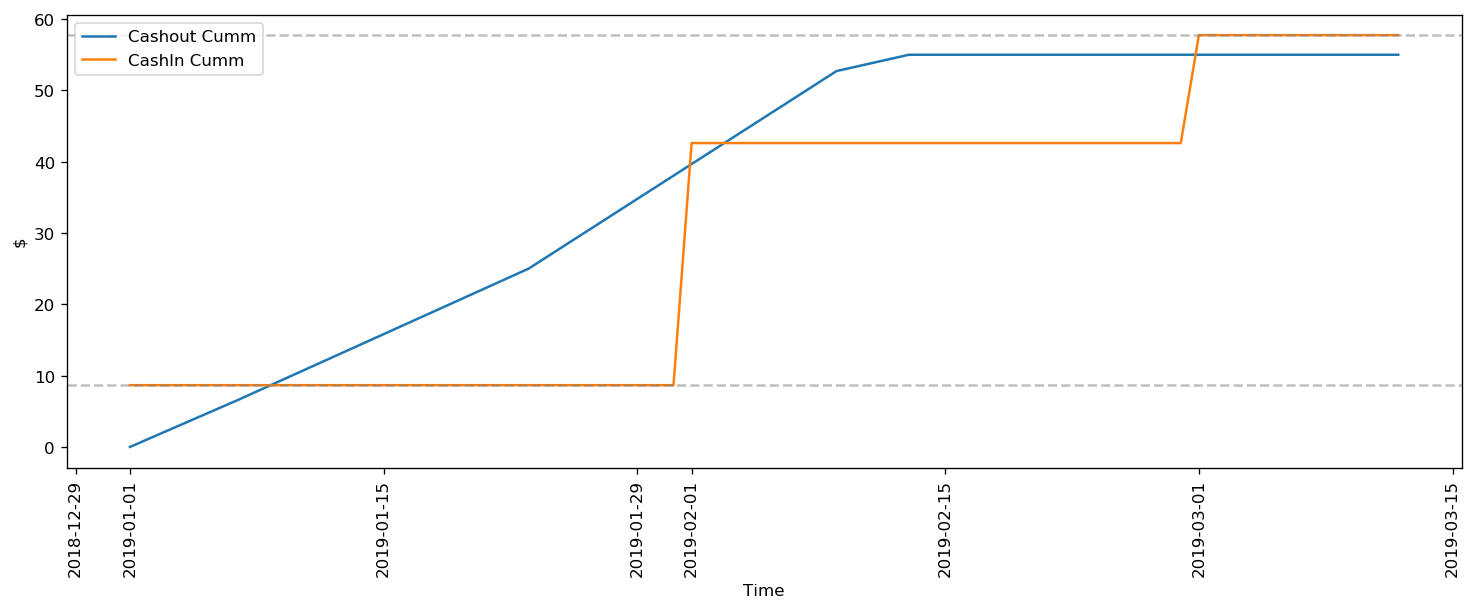

In [9]:
plt.figure()
plt.plot(project.time, project.cashout.cumsum(), label="Cashout Cumm")
plt.plot(project.time, project.cashin.cumsum(), label="CashIn Cumm")
plt.axhline(project.cost.sum() * (1 + project.markup), linestyle="--", color="grey", alpha=0.5)
plt.axhline(project.cost.sum() * (1 + project.markup) * project.downpayment, linestyle="--", color="grey", alpha=0.5)
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=2)
plt.show()

### Overdraft

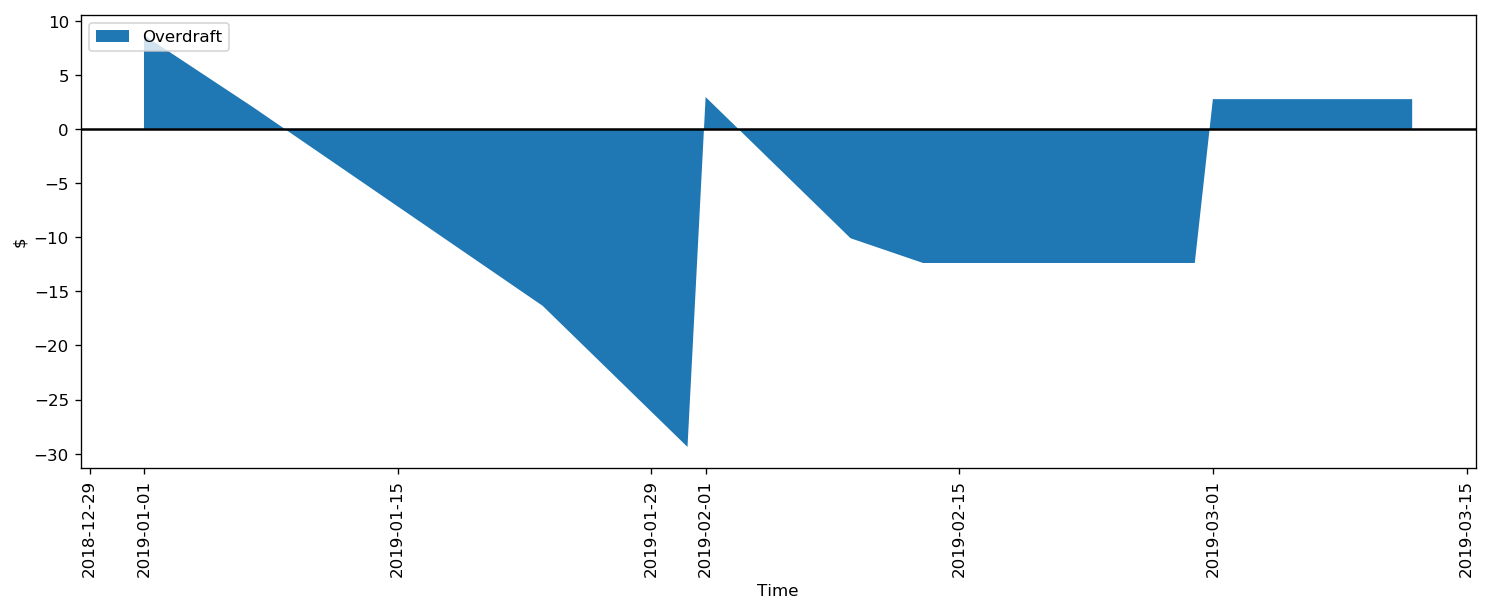

In [10]:
plt.figure()
plt.fill_between(project.time, (project.cashin.cumsum() - project.cashout.cumsum()), label="Overdraft")
plt.axhline(0, color="Black")
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=2)
plt.show()

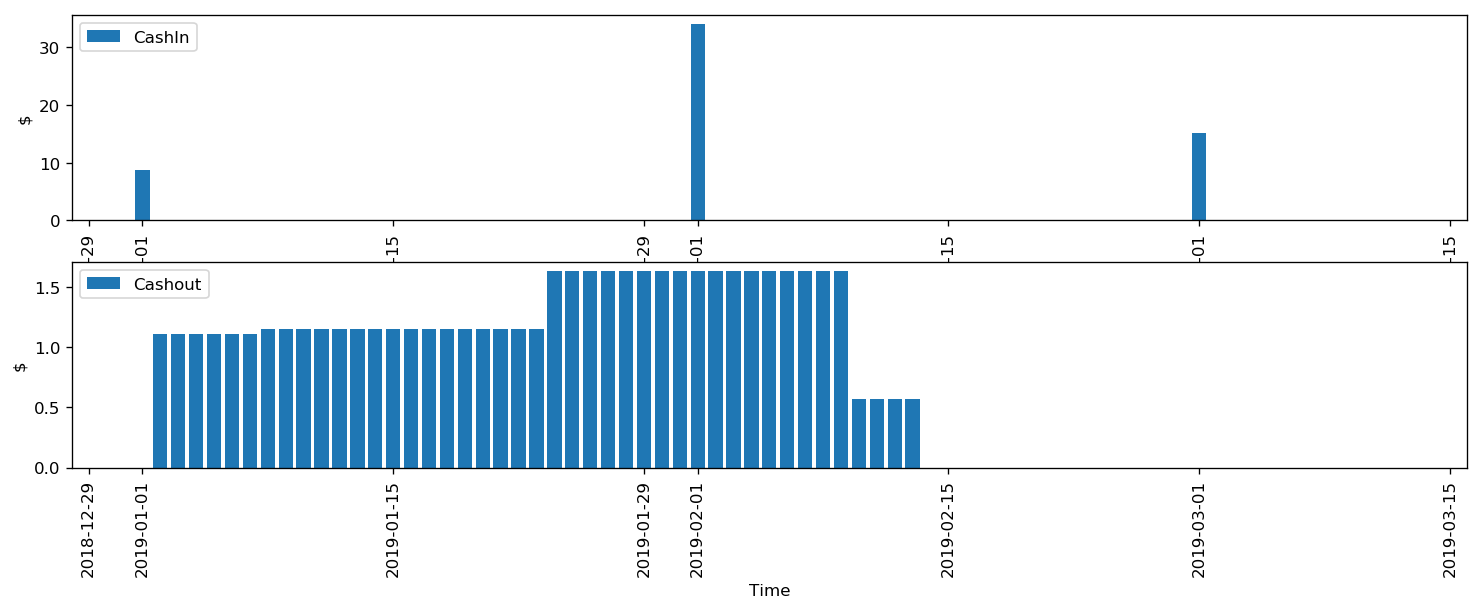

In [11]:
ax = plt.subplot(211)
plt.bar(project.time, project.cashin, label="CashIn")
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=2)
plt.xticks(ticks=[])
plt.subplot(212, sharex=ax)
plt.bar(project.time, project.cashout, label="Cashout")
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=2)
plt.show()

### Optimization

[22:59:58]INFO: Done 0% @ Iteration 0
[22:59:58]INFO: Found better solution at iteration 1 from -26.41160236822001 to -26.41160236822001
[22:59:58]INFO: Found better solution at iteration 3 from -24.839409854851027 to -24.839409854851027
[22:59:58]INFO: Same lag tested! skipping iteration 6
[22:59:58]INFO: Same lag tested! skipping iteration 8
[22:59:58]INFO: Same lag tested! skipping iteration 10
[22:59:58]INFO: Same lag tested! skipping iteration 17
[22:59:58]INFO: Same lag tested! skipping iteration 20
[22:59:58]INFO: Same lag tested! skipping iteration 28
[22:59:58]INFO: Same lag tested! skipping iteration 29
[22:59:58]INFO: Same lag tested! skipping iteration 30
[22:59:58]INFO: Same lag tested! skipping iteration 32
[22:59:58]INFO: Same lag tested! skipping iteration 40
[22:59:58]INFO: Same lag tested! skipping iteration 41
[22:59:58]INFO: Same lag tested! skipping iteration 42
[22:59:58]INFO: Same lag tested! skipping iteration 44
[22:59:58]INFO: Same lag tested! skipping iterati

[22:59:59]INFO: Same lag tested! skipping iteration 223
[22:59:59]INFO: Same lag tested! skipping iteration 224
[22:59:59]INFO: Same lag tested! skipping iteration 225
[22:59:59]INFO: Same lag tested! skipping iteration 226
[22:59:59]INFO: Same lag tested! skipping iteration 227
[22:59:59]INFO: Same lag tested! skipping iteration 228
[22:59:59]INFO: Same lag tested! skipping iteration 229
[22:59:59]INFO: Same lag tested! skipping iteration 230
[22:59:59]INFO: Same lag tested! skipping iteration 231
[22:59:59]INFO: Same lag tested! skipping iteration 232
[22:59:59]INFO: Same lag tested! skipping iteration 233
[22:59:59]INFO: Same lag tested! skipping iteration 234
[22:59:59]INFO: Same lag tested! skipping iteration 235
[22:59:59]INFO: Same lag tested! skipping iteration 236
[22:59:59]INFO: Same lag tested! skipping iteration 237
[22:59:59]INFO: Same lag tested! skipping iteration 238
[22:59:59]INFO: Same lag tested! skipping iteration 239
[22:59:59]INFO: Same lag tested! skipping iterat

[22:59:59]INFO: Same lag tested! skipping iteration 372
[22:59:59]INFO: Same lag tested! skipping iteration 373
[22:59:59]INFO: Same lag tested! skipping iteration 374
[22:59:59]INFO: Same lag tested! skipping iteration 375
[22:59:59]INFO: Same lag tested! skipping iteration 376
[22:59:59]INFO: Same lag tested! skipping iteration 377
[22:59:59]INFO: Same lag tested! skipping iteration 378
[22:59:59]INFO: Same lag tested! skipping iteration 379
[22:59:59]INFO: Same lag tested! skipping iteration 380
[22:59:59]INFO: Same lag tested! skipping iteration 381
[22:59:59]INFO: Same lag tested! skipping iteration 382
[22:59:59]INFO: Same lag tested! skipping iteration 383
[22:59:59]INFO: Same lag tested! skipping iteration 384
[22:59:59]INFO: Same lag tested! skipping iteration 385
[22:59:59]INFO: Same lag tested! skipping iteration 386
[22:59:59]INFO: Same lag tested! skipping iteration 387
[22:59:59]INFO: Same lag tested! skipping iteration 388
[22:59:59]INFO: Same lag tested! skipping iterat

[22:59:59]INFO: Same lag tested! skipping iteration 518
[22:59:59]INFO: Same lag tested! skipping iteration 519
[22:59:59]INFO: Same lag tested! skipping iteration 520
[22:59:59]INFO: Same lag tested! skipping iteration 521
[22:59:59]INFO: Same lag tested! skipping iteration 522
[22:59:59]INFO: Same lag tested! skipping iteration 523
[22:59:59]INFO: Same lag tested! skipping iteration 524
[22:59:59]INFO: Same lag tested! skipping iteration 525
[22:59:59]INFO: Same lag tested! skipping iteration 526
[22:59:59]INFO: Same lag tested! skipping iteration 527
[22:59:59]INFO: Same lag tested! skipping iteration 528
[22:59:59]INFO: Same lag tested! skipping iteration 529
[22:59:59]INFO: Same lag tested! skipping iteration 530
[22:59:59]INFO: Same lag tested! skipping iteration 531
[22:59:59]INFO: Same lag tested! skipping iteration 532
[22:59:59]INFO: Same lag tested! skipping iteration 533
[22:59:59]INFO: Same lag tested! skipping iteration 534
[22:59:59]INFO: Same lag tested! skipping iterat

[22:59:59]INFO: Same lag tested! skipping iteration 665
[22:59:59]INFO: Same lag tested! skipping iteration 666
[22:59:59]INFO: Same lag tested! skipping iteration 667
[22:59:59]INFO: Same lag tested! skipping iteration 668
[22:59:59]INFO: Same lag tested! skipping iteration 669
[22:59:59]INFO: Same lag tested! skipping iteration 670
[22:59:59]INFO: Same lag tested! skipping iteration 671
[22:59:59]INFO: Same lag tested! skipping iteration 672
[22:59:59]INFO: Same lag tested! skipping iteration 673
[22:59:59]INFO: Same lag tested! skipping iteration 674
[22:59:59]INFO: Same lag tested! skipping iteration 675
[22:59:59]INFO: Same lag tested! skipping iteration 676
[22:59:59]INFO: Same lag tested! skipping iteration 677
[22:59:59]INFO: Same lag tested! skipping iteration 678
[22:59:59]INFO: Same lag tested! skipping iteration 679
[22:59:59]INFO: Same lag tested! skipping iteration 680
[22:59:59]INFO: Same lag tested! skipping iteration 681
[22:59:59]INFO: Same lag tested! skipping iterat

[22:59:59]INFO: Same lag tested! skipping iteration 812
[22:59:59]INFO: Same lag tested! skipping iteration 813
[22:59:59]INFO: Same lag tested! skipping iteration 814
[22:59:59]INFO: Same lag tested! skipping iteration 815
[22:59:59]INFO: Same lag tested! skipping iteration 816
[22:59:59]INFO: Same lag tested! skipping iteration 817
[22:59:59]INFO: Same lag tested! skipping iteration 818
[22:59:59]INFO: Same lag tested! skipping iteration 819
[22:59:59]INFO: Same lag tested! skipping iteration 820
[22:59:59]INFO: Same lag tested! skipping iteration 821
[22:59:59]INFO: Same lag tested! skipping iteration 822
[22:59:59]INFO: Same lag tested! skipping iteration 823
[22:59:59]INFO: Same lag tested! skipping iteration 824
[22:59:59]INFO: Same lag tested! skipping iteration 825
[22:59:59]INFO: Same lag tested! skipping iteration 826
[22:59:59]INFO: Same lag tested! skipping iteration 827
[22:59:59]INFO: Same lag tested! skipping iteration 828
[22:59:59]INFO: Same lag tested! skipping iterat

[23:00:00]INFO: Same lag tested! skipping iteration 959
[23:00:00]INFO: Same lag tested! skipping iteration 960
[23:00:00]INFO: Same lag tested! skipping iteration 961
[23:00:00]INFO: Same lag tested! skipping iteration 962
[23:00:00]INFO: Same lag tested! skipping iteration 963
[23:00:00]INFO: Same lag tested! skipping iteration 964
[23:00:00]INFO: Same lag tested! skipping iteration 965
[23:00:00]INFO: Same lag tested! skipping iteration 966
[23:00:00]INFO: Same lag tested! skipping iteration 967
[23:00:00]INFO: Same lag tested! skipping iteration 968
[23:00:00]INFO: Same lag tested! skipping iteration 969
[23:00:00]INFO: Same lag tested! skipping iteration 970
[23:00:00]INFO: Same lag tested! skipping iteration 971
[23:00:00]INFO: Same lag tested! skipping iteration 972
[23:00:00]INFO: Same lag tested! skipping iteration 973
[23:00:00]INFO: Same lag tested! skipping iteration 974
[23:00:00]INFO: Same lag tested! skipping iteration 975
[23:00:00]INFO: Same lag tested! skipping iterat

[23:00:00]INFO: Same lag tested! skipping iteration 1104
[23:00:00]INFO: Same lag tested! skipping iteration 1105
[23:00:00]INFO: Same lag tested! skipping iteration 1106
[23:00:00]INFO: Same lag tested! skipping iteration 1107
[23:00:00]INFO: Same lag tested! skipping iteration 1108
[23:00:00]INFO: Same lag tested! skipping iteration 1109
[23:00:00]INFO: Same lag tested! skipping iteration 1110
[23:00:00]INFO: Same lag tested! skipping iteration 1111
[23:00:00]INFO: Same lag tested! skipping iteration 1112
[23:00:00]INFO: Same lag tested! skipping iteration 1113
[23:00:00]INFO: Same lag tested! skipping iteration 1114
[23:00:00]INFO: Same lag tested! skipping iteration 1115
[23:00:00]INFO: Same lag tested! skipping iteration 1116
[23:00:00]INFO: Same lag tested! skipping iteration 1117
[23:00:00]INFO: Same lag tested! skipping iteration 1118
[23:00:00]INFO: Same lag tested! skipping iteration 1119
[23:00:00]INFO: Same lag tested! skipping iteration 1120
[23:00:00]INFO: Same lag tested

[23:00:00]INFO: Same lag tested! skipping iteration 1248
[23:00:00]INFO: Same lag tested! skipping iteration 1249
[23:00:00]INFO: Same lag tested! skipping iteration 1250
[23:00:00]INFO: Same lag tested! skipping iteration 1251
[23:00:00]INFO: Same lag tested! skipping iteration 1252
[23:00:00]INFO: Same lag tested! skipping iteration 1253
[23:00:00]INFO: Same lag tested! skipping iteration 1254
[23:00:00]INFO: Same lag tested! skipping iteration 1255
[23:00:00]INFO: Same lag tested! skipping iteration 1256
[23:00:00]INFO: Same lag tested! skipping iteration 1257
[23:00:00]INFO: Same lag tested! skipping iteration 1258
[23:00:00]INFO: Same lag tested! skipping iteration 1259
[23:00:00]INFO: Same lag tested! skipping iteration 1260
[23:00:00]INFO: Same lag tested! skipping iteration 1261
[23:00:00]INFO: Same lag tested! skipping iteration 1262
[23:00:00]INFO: Same lag tested! skipping iteration 1263
[23:00:00]INFO: Same lag tested! skipping iteration 1264
[23:00:00]INFO: Same lag tested

[23:00:00]INFO: Same lag tested! skipping iteration 1392
[23:00:00]INFO: Same lag tested! skipping iteration 1393
[23:00:00]INFO: Same lag tested! skipping iteration 1394
[23:00:00]INFO: Same lag tested! skipping iteration 1395
[23:00:00]INFO: Same lag tested! skipping iteration 1396
[23:00:00]INFO: Same lag tested! skipping iteration 1397
[23:00:00]INFO: Same lag tested! skipping iteration 1398
[23:00:00]INFO: Same lag tested! skipping iteration 1399
[23:00:00]INFO: Same lag tested! skipping iteration 1400
[23:00:00]INFO: Same lag tested! skipping iteration 1401
[23:00:00]INFO: Same lag tested! skipping iteration 1402
[23:00:00]INFO: Same lag tested! skipping iteration 1403
[23:00:00]INFO: Same lag tested! skipping iteration 1404
[23:00:00]INFO: Same lag tested! skipping iteration 1405
[23:00:00]INFO: Same lag tested! skipping iteration 1406
[23:00:00]INFO: Same lag tested! skipping iteration 1407
[23:00:00]INFO: Same lag tested! skipping iteration 1408
[23:00:00]INFO: Same lag tested

[23:00:01]INFO: Same lag tested! skipping iteration 1536
[23:00:01]INFO: Same lag tested! skipping iteration 1537
[23:00:01]INFO: Same lag tested! skipping iteration 1538
[23:00:01]INFO: Same lag tested! skipping iteration 1539
[23:00:01]INFO: Same lag tested! skipping iteration 1540
[23:00:01]INFO: Same lag tested! skipping iteration 1541
[23:00:01]INFO: Same lag tested! skipping iteration 1542
[23:00:01]INFO: Same lag tested! skipping iteration 1543
[23:00:01]INFO: Same lag tested! skipping iteration 1544
[23:00:01]INFO: Same lag tested! skipping iteration 1545
[23:00:01]INFO: Same lag tested! skipping iteration 1546
[23:00:01]INFO: Same lag tested! skipping iteration 1547
[23:00:01]INFO: Same lag tested! skipping iteration 1548
[23:00:01]INFO: Same lag tested! skipping iteration 1549
[23:00:01]INFO: Same lag tested! skipping iteration 1550
[23:00:01]INFO: Same lag tested! skipping iteration 1551
[23:00:01]INFO: Same lag tested! skipping iteration 1552
[23:00:01]INFO: Same lag tested

[23:00:01]INFO: Same lag tested! skipping iteration 1680
[23:00:01]INFO: Same lag tested! skipping iteration 1681
[23:00:01]INFO: Same lag tested! skipping iteration 1682
[23:00:01]INFO: Same lag tested! skipping iteration 1683
[23:00:01]INFO: Same lag tested! skipping iteration 1684
[23:00:01]INFO: Same lag tested! skipping iteration 1685
[23:00:01]INFO: Same lag tested! skipping iteration 1686
[23:00:01]INFO: Same lag tested! skipping iteration 1687
[23:00:01]INFO: Same lag tested! skipping iteration 1688
[23:00:01]INFO: Same lag tested! skipping iteration 1689
[23:00:01]INFO: Same lag tested! skipping iteration 1690
[23:00:01]INFO: Same lag tested! skipping iteration 1691
[23:00:01]INFO: Same lag tested! skipping iteration 1692
[23:00:01]INFO: Same lag tested! skipping iteration 1693
[23:00:01]INFO: Same lag tested! skipping iteration 1694
[23:00:01]INFO: Same lag tested! skipping iteration 1695
[23:00:01]INFO: Same lag tested! skipping iteration 1696
[23:00:01]INFO: Same lag tested

[23:00:01]INFO: Same lag tested! skipping iteration 1824
[23:00:01]INFO: Same lag tested! skipping iteration 1825
[23:00:01]INFO: Same lag tested! skipping iteration 1826
[23:00:01]INFO: Same lag tested! skipping iteration 1827
[23:00:01]INFO: Same lag tested! skipping iteration 1828
[23:00:01]INFO: Same lag tested! skipping iteration 1829
[23:00:01]INFO: Same lag tested! skipping iteration 1830
[23:00:01]INFO: Same lag tested! skipping iteration 1831
[23:00:01]INFO: Same lag tested! skipping iteration 1832
[23:00:01]INFO: Same lag tested! skipping iteration 1833
[23:00:01]INFO: Same lag tested! skipping iteration 1834
[23:00:01]INFO: Same lag tested! skipping iteration 1835
[23:00:01]INFO: Same lag tested! skipping iteration 1836
[23:00:01]INFO: Same lag tested! skipping iteration 1837
[23:00:01]INFO: Same lag tested! skipping iteration 1838
[23:00:01]INFO: Same lag tested! skipping iteration 1839
[23:00:01]INFO: Same lag tested! skipping iteration 1840
[23:00:01]INFO: Same lag tested

[23:00:01]INFO: Same lag tested! skipping iteration 1968
[23:00:01]INFO: Same lag tested! skipping iteration 1969
[23:00:01]INFO: Same lag tested! skipping iteration 1970
[23:00:01]INFO: Same lag tested! skipping iteration 1971
[23:00:01]INFO: Same lag tested! skipping iteration 1972
[23:00:01]INFO: Same lag tested! skipping iteration 1973
[23:00:01]INFO: Same lag tested! skipping iteration 1974
[23:00:01]INFO: Same lag tested! skipping iteration 1975
[23:00:01]INFO: Same lag tested! skipping iteration 1976
[23:00:01]INFO: Same lag tested! skipping iteration 1977
[23:00:01]INFO: Same lag tested! skipping iteration 1978
[23:00:01]INFO: Same lag tested! skipping iteration 1979
[23:00:01]INFO: Same lag tested! skipping iteration 1980
[23:00:01]INFO: Same lag tested! skipping iteration 1981
[23:00:01]INFO: Same lag tested! skipping iteration 1982
[23:00:01]INFO: Same lag tested! skipping iteration 1983
[23:00:01]INFO: Same lag tested! skipping iteration 1984
[23:00:01]INFO: Same lag tested

[23:00:01]INFO: Same lag tested! skipping iteration 2112
[23:00:01]INFO: Same lag tested! skipping iteration 2113
[23:00:01]INFO: Same lag tested! skipping iteration 2114
[23:00:01]INFO: Same lag tested! skipping iteration 2115
[23:00:01]INFO: Same lag tested! skipping iteration 2116
[23:00:01]INFO: Same lag tested! skipping iteration 2117
[23:00:01]INFO: Same lag tested! skipping iteration 2118
[23:00:01]INFO: Same lag tested! skipping iteration 2119
[23:00:01]INFO: Same lag tested! skipping iteration 2120
[23:00:01]INFO: Same lag tested! skipping iteration 2121
[23:00:01]INFO: Same lag tested! skipping iteration 2122
[23:00:01]INFO: Same lag tested! skipping iteration 2123
[23:00:01]INFO: Same lag tested! skipping iteration 2124
[23:00:01]INFO: Same lag tested! skipping iteration 2125
[23:00:01]INFO: Same lag tested! skipping iteration 2126
[23:00:01]INFO: Same lag tested! skipping iteration 2127
[23:00:01]INFO: Same lag tested! skipping iteration 2128
[23:00:01]INFO: Same lag tested

[23:00:02]INFO: Same lag tested! skipping iteration 2256
[23:00:02]INFO: Same lag tested! skipping iteration 2257
[23:00:02]INFO: Same lag tested! skipping iteration 2258
[23:00:02]INFO: Same lag tested! skipping iteration 2259
[23:00:02]INFO: Same lag tested! skipping iteration 2260
[23:00:02]INFO: Same lag tested! skipping iteration 2261
[23:00:02]INFO: Same lag tested! skipping iteration 2262
[23:00:02]INFO: Same lag tested! skipping iteration 2263
[23:00:02]INFO: Same lag tested! skipping iteration 2264
[23:00:02]INFO: Same lag tested! skipping iteration 2265
[23:00:02]INFO: Same lag tested! skipping iteration 2266
[23:00:02]INFO: Same lag tested! skipping iteration 2267
[23:00:02]INFO: Same lag tested! skipping iteration 2268
[23:00:02]INFO: Same lag tested! skipping iteration 2269
[23:00:02]INFO: Same lag tested! skipping iteration 2270
[23:00:02]INFO: Same lag tested! skipping iteration 2271
[23:00:02]INFO: Same lag tested! skipping iteration 2272
[23:00:02]INFO: Same lag tested

[23:00:02]INFO: Same lag tested! skipping iteration 2400
[23:00:02]INFO: Same lag tested! skipping iteration 2401
[23:00:02]INFO: Same lag tested! skipping iteration 2402
[23:00:02]INFO: Same lag tested! skipping iteration 2403
[23:00:02]INFO: Same lag tested! skipping iteration 2404
[23:00:02]INFO: Same lag tested! skipping iteration 2405
[23:00:02]INFO: Same lag tested! skipping iteration 2406
[23:00:02]INFO: Same lag tested! skipping iteration 2407
[23:00:02]INFO: Same lag tested! skipping iteration 2408
[23:00:02]INFO: Same lag tested! skipping iteration 2409
[23:00:02]INFO: Same lag tested! skipping iteration 2410
[23:00:02]INFO: Same lag tested! skipping iteration 2411
[23:00:02]INFO: Same lag tested! skipping iteration 2412
[23:00:02]INFO: Same lag tested! skipping iteration 2413
[23:00:02]INFO: Same lag tested! skipping iteration 2414
[23:00:02]INFO: Same lag tested! skipping iteration 2415
[23:00:02]INFO: Same lag tested! skipping iteration 2416
[23:00:02]INFO: Same lag tested

[23:00:02]INFO: Same lag tested! skipping iteration 2544
[23:00:02]INFO: Same lag tested! skipping iteration 2545
[23:00:02]INFO: Same lag tested! skipping iteration 2546
[23:00:02]INFO: Same lag tested! skipping iteration 2547
[23:00:02]INFO: Same lag tested! skipping iteration 2548
[23:00:02]INFO: Same lag tested! skipping iteration 2549
[23:00:02]INFO: Same lag tested! skipping iteration 2550
[23:00:02]INFO: Same lag tested! skipping iteration 2551
[23:00:02]INFO: Same lag tested! skipping iteration 2552
[23:00:02]INFO: Same lag tested! skipping iteration 2553
[23:00:02]INFO: Same lag tested! skipping iteration 2554
[23:00:02]INFO: Same lag tested! skipping iteration 2555
[23:00:02]INFO: Same lag tested! skipping iteration 2556
[23:00:02]INFO: Same lag tested! skipping iteration 2557
[23:00:02]INFO: Same lag tested! skipping iteration 2558
[23:00:02]INFO: Same lag tested! skipping iteration 2559
[23:00:02]INFO: Same lag tested! skipping iteration 2560
[23:00:02]INFO: Same lag tested

[23:00:02]INFO: Same lag tested! skipping iteration 2688
[23:00:02]INFO: Same lag tested! skipping iteration 2689
[23:00:02]INFO: Same lag tested! skipping iteration 2690
[23:00:02]INFO: Same lag tested! skipping iteration 2691
[23:00:02]INFO: Same lag tested! skipping iteration 2692
[23:00:02]INFO: Same lag tested! skipping iteration 2693
[23:00:02]INFO: Same lag tested! skipping iteration 2694
[23:00:02]INFO: Same lag tested! skipping iteration 2695
[23:00:02]INFO: Same lag tested! skipping iteration 2696
[23:00:02]INFO: Same lag tested! skipping iteration 2697
[23:00:02]INFO: Same lag tested! skipping iteration 2698
[23:00:02]INFO: Same lag tested! skipping iteration 2699
[23:00:02]INFO: Same lag tested! skipping iteration 2700
[23:00:02]INFO: Same lag tested! skipping iteration 2701
[23:00:02]INFO: Same lag tested! skipping iteration 2702
[23:00:02]INFO: Same lag tested! skipping iteration 2703
[23:00:02]INFO: Same lag tested! skipping iteration 2704
[23:00:02]INFO: Same lag tested

[23:00:03]INFO: Same lag tested! skipping iteration 2832
[23:00:03]INFO: Same lag tested! skipping iteration 2833
[23:00:03]INFO: Same lag tested! skipping iteration 2834
[23:00:03]INFO: Same lag tested! skipping iteration 2835
[23:00:03]INFO: Same lag tested! skipping iteration 2836
[23:00:03]INFO: Same lag tested! skipping iteration 2837
[23:00:03]INFO: Same lag tested! skipping iteration 2838
[23:00:03]INFO: Same lag tested! skipping iteration 2839
[23:00:03]INFO: Same lag tested! skipping iteration 2840
[23:00:03]INFO: Same lag tested! skipping iteration 2841
[23:00:03]INFO: Same lag tested! skipping iteration 2842
[23:00:03]INFO: Same lag tested! skipping iteration 2843
[23:00:03]INFO: Same lag tested! skipping iteration 2844
[23:00:03]INFO: Same lag tested! skipping iteration 2845
[23:00:03]INFO: Same lag tested! skipping iteration 2846
[23:00:03]INFO: Same lag tested! skipping iteration 2847
[23:00:03]INFO: Same lag tested! skipping iteration 2848
[23:00:03]INFO: Same lag tested

[23:00:03]INFO: Same lag tested! skipping iteration 2975
[23:00:03]INFO: Same lag tested! skipping iteration 2976
[23:00:03]INFO: Same lag tested! skipping iteration 2977
[23:00:03]INFO: Same lag tested! skipping iteration 2978
[23:00:03]INFO: Same lag tested! skipping iteration 2979
[23:00:03]INFO: Same lag tested! skipping iteration 2980
[23:00:03]INFO: Same lag tested! skipping iteration 2981
[23:00:03]INFO: Same lag tested! skipping iteration 2982
[23:00:03]INFO: Same lag tested! skipping iteration 2983
[23:00:03]INFO: Same lag tested! skipping iteration 2984
[23:00:03]INFO: Same lag tested! skipping iteration 2985
[23:00:03]INFO: Same lag tested! skipping iteration 2986
[23:00:03]INFO: Same lag tested! skipping iteration 2987
[23:00:03]INFO: Same lag tested! skipping iteration 2988
[23:00:03]INFO: Same lag tested! skipping iteration 2989
[23:00:03]INFO: Same lag tested! skipping iteration 2990
[23:00:03]INFO: Same lag tested! skipping iteration 2991
[23:00:03]INFO: Same lag tested

[23:00:03]INFO: Same lag tested! skipping iteration 3119
[23:00:03]INFO: Same lag tested! skipping iteration 3120
[23:00:03]INFO: Same lag tested! skipping iteration 3121
[23:00:03]INFO: Same lag tested! skipping iteration 3122
[23:00:03]INFO: Same lag tested! skipping iteration 3123
[23:00:03]INFO: Same lag tested! skipping iteration 3124
[23:00:03]INFO: Same lag tested! skipping iteration 3125
[23:00:03]INFO: Same lag tested! skipping iteration 3126
[23:00:03]INFO: Same lag tested! skipping iteration 3127
[23:00:03]INFO: Same lag tested! skipping iteration 3128
[23:00:03]INFO: Same lag tested! skipping iteration 3129
[23:00:03]INFO: Same lag tested! skipping iteration 3130
[23:00:03]INFO: Same lag tested! skipping iteration 3131
[23:00:03]INFO: Same lag tested! skipping iteration 3132
[23:00:03]INFO: Same lag tested! skipping iteration 3133
[23:00:03]INFO: Same lag tested! skipping iteration 3134
[23:00:03]INFO: Same lag tested! skipping iteration 3135
[23:00:03]INFO: Same lag tested

[23:00:03]INFO: Same lag tested! skipping iteration 3263
[23:00:03]INFO: Same lag tested! skipping iteration 3264
[23:00:03]INFO: Same lag tested! skipping iteration 3265
[23:00:03]INFO: Same lag tested! skipping iteration 3266
[23:00:03]INFO: Same lag tested! skipping iteration 3267
[23:00:03]INFO: Same lag tested! skipping iteration 3268
[23:00:03]INFO: Same lag tested! skipping iteration 3269
[23:00:03]INFO: Same lag tested! skipping iteration 3270
[23:00:03]INFO: Same lag tested! skipping iteration 3271
[23:00:03]INFO: Same lag tested! skipping iteration 3272
[23:00:03]INFO: Same lag tested! skipping iteration 3273
[23:00:03]INFO: Same lag tested! skipping iteration 3274
[23:00:03]INFO: Same lag tested! skipping iteration 3275
[23:00:03]INFO: Same lag tested! skipping iteration 3276
[23:00:03]INFO: Same lag tested! skipping iteration 3277
[23:00:03]INFO: Same lag tested! skipping iteration 3278
[23:00:03]INFO: Same lag tested! skipping iteration 3279
[23:00:03]INFO: Same lag tested

[23:00:03]INFO: Same lag tested! skipping iteration 3407
[23:00:03]INFO: Same lag tested! skipping iteration 3408
[23:00:03]INFO: Same lag tested! skipping iteration 3409
[23:00:03]INFO: Same lag tested! skipping iteration 3410
[23:00:03]INFO: Same lag tested! skipping iteration 3411
[23:00:03]INFO: Same lag tested! skipping iteration 3412
[23:00:03]INFO: Same lag tested! skipping iteration 3413
[23:00:03]INFO: Same lag tested! skipping iteration 3414
[23:00:03]INFO: Same lag tested! skipping iteration 3415
[23:00:03]INFO: Same lag tested! skipping iteration 3416
[23:00:03]INFO: Same lag tested! skipping iteration 3417
[23:00:03]INFO: Same lag tested! skipping iteration 3418
[23:00:03]INFO: Same lag tested! skipping iteration 3419
[23:00:03]INFO: Same lag tested! skipping iteration 3420
[23:00:03]INFO: Same lag tested! skipping iteration 3421
[23:00:03]INFO: Same lag tested! skipping iteration 3422
[23:00:03]INFO: Same lag tested! skipping iteration 3423
[23:00:03]INFO: Same lag tested

[23:00:04]INFO: Same lag tested! skipping iteration 3551
[23:00:04]INFO: Same lag tested! skipping iteration 3552
[23:00:04]INFO: Same lag tested! skipping iteration 3553
[23:00:04]INFO: Same lag tested! skipping iteration 3554
[23:00:04]INFO: Same lag tested! skipping iteration 3555
[23:00:04]INFO: Same lag tested! skipping iteration 3556
[23:00:04]INFO: Same lag tested! skipping iteration 3557
[23:00:04]INFO: Same lag tested! skipping iteration 3558
[23:00:04]INFO: Same lag tested! skipping iteration 3559
[23:00:04]INFO: Same lag tested! skipping iteration 3560
[23:00:04]INFO: Same lag tested! skipping iteration 3561
[23:00:04]INFO: Same lag tested! skipping iteration 3562
[23:00:04]INFO: Same lag tested! skipping iteration 3563
[23:00:04]INFO: Same lag tested! skipping iteration 3564
[23:00:04]INFO: Same lag tested! skipping iteration 3565
[23:00:04]INFO: Same lag tested! skipping iteration 3566
[23:00:04]INFO: Same lag tested! skipping iteration 3567
[23:00:04]INFO: Same lag tested

[23:00:04]INFO: Same lag tested! skipping iteration 3695
[23:00:04]INFO: Same lag tested! skipping iteration 3696
[23:00:04]INFO: Same lag tested! skipping iteration 3697
[23:00:04]INFO: Same lag tested! skipping iteration 3698
[23:00:04]INFO: Same lag tested! skipping iteration 3699
[23:00:04]INFO: Same lag tested! skipping iteration 3700
[23:00:04]INFO: Same lag tested! skipping iteration 3701
[23:00:04]INFO: Same lag tested! skipping iteration 3702
[23:00:04]INFO: Same lag tested! skipping iteration 3703
[23:00:04]INFO: Same lag tested! skipping iteration 3704
[23:00:04]INFO: Same lag tested! skipping iteration 3705
[23:00:04]INFO: Same lag tested! skipping iteration 3706
[23:00:04]INFO: Same lag tested! skipping iteration 3707
[23:00:04]INFO: Same lag tested! skipping iteration 3708
[23:00:04]INFO: Same lag tested! skipping iteration 3709
[23:00:04]INFO: Same lag tested! skipping iteration 3710
[23:00:04]INFO: Same lag tested! skipping iteration 3711
[23:00:04]INFO: Same lag tested

[23:00:04]INFO: Same lag tested! skipping iteration 3839
[23:00:04]INFO: Same lag tested! skipping iteration 3840
[23:00:04]INFO: Same lag tested! skipping iteration 3841
[23:00:04]INFO: Same lag tested! skipping iteration 3842
[23:00:04]INFO: Same lag tested! skipping iteration 3843
[23:00:04]INFO: Same lag tested! skipping iteration 3844
[23:00:04]INFO: Same lag tested! skipping iteration 3845
[23:00:04]INFO: Same lag tested! skipping iteration 3846
[23:00:04]INFO: Same lag tested! skipping iteration 3847
[23:00:04]INFO: Same lag tested! skipping iteration 3848
[23:00:04]INFO: Same lag tested! skipping iteration 3849
[23:00:04]INFO: Same lag tested! skipping iteration 3850
[23:00:04]INFO: Same lag tested! skipping iteration 3851
[23:00:04]INFO: Same lag tested! skipping iteration 3852
[23:00:04]INFO: Same lag tested! skipping iteration 3853
[23:00:04]INFO: Same lag tested! skipping iteration 3854
[23:00:04]INFO: Same lag tested! skipping iteration 3855
[23:00:04]INFO: Same lag tested

[23:00:04]INFO: Same lag tested! skipping iteration 3983
[23:00:04]INFO: Same lag tested! skipping iteration 3984
[23:00:04]INFO: Same lag tested! skipping iteration 3985
[23:00:04]INFO: Same lag tested! skipping iteration 3986
[23:00:04]INFO: Same lag tested! skipping iteration 3987
[23:00:04]INFO: Same lag tested! skipping iteration 3988
[23:00:04]INFO: Same lag tested! skipping iteration 3989
[23:00:04]INFO: Same lag tested! skipping iteration 3990
[23:00:04]INFO: Same lag tested! skipping iteration 3991
[23:00:04]INFO: Same lag tested! skipping iteration 3992
[23:00:04]INFO: Same lag tested! skipping iteration 3993
[23:00:04]INFO: Same lag tested! skipping iteration 3994
[23:00:04]INFO: Same lag tested! skipping iteration 3995
[23:00:04]INFO: Same lag tested! skipping iteration 3996
[23:00:04]INFO: Same lag tested! skipping iteration 3997
[23:00:04]INFO: Same lag tested! skipping iteration 3998
[23:00:04]INFO: Same lag tested! skipping iteration 3999
[23:00:04]INFO: Same lag tested

[23:00:04]INFO: Same lag tested! skipping iteration 4127
[23:00:04]INFO: Same lag tested! skipping iteration 4128
[23:00:04]INFO: Same lag tested! skipping iteration 4129
[23:00:04]INFO: Same lag tested! skipping iteration 4130
[23:00:04]INFO: Same lag tested! skipping iteration 4131
[23:00:05]INFO: Same lag tested! skipping iteration 4132
[23:00:05]INFO: Same lag tested! skipping iteration 4133
[23:00:05]INFO: Same lag tested! skipping iteration 4134
[23:00:05]INFO: Same lag tested! skipping iteration 4135
[23:00:05]INFO: Same lag tested! skipping iteration 4136
[23:00:05]INFO: Same lag tested! skipping iteration 4137
[23:00:05]INFO: Same lag tested! skipping iteration 4138
[23:00:05]INFO: Same lag tested! skipping iteration 4139
[23:00:05]INFO: Same lag tested! skipping iteration 4140
[23:00:05]INFO: Same lag tested! skipping iteration 4141
[23:00:05]INFO: Same lag tested! skipping iteration 4142
[23:00:05]INFO: Same lag tested! skipping iteration 4143
[23:00:05]INFO: Same lag tested

[23:00:05]INFO: Same lag tested! skipping iteration 4271
[23:00:05]INFO: Same lag tested! skipping iteration 4272
[23:00:05]INFO: Same lag tested! skipping iteration 4273
[23:00:05]INFO: Same lag tested! skipping iteration 4274
[23:00:05]INFO: Same lag tested! skipping iteration 4275
[23:00:05]INFO: Same lag tested! skipping iteration 4276
[23:00:05]INFO: Same lag tested! skipping iteration 4277
[23:00:05]INFO: Same lag tested! skipping iteration 4278
[23:00:05]INFO: Same lag tested! skipping iteration 4279
[23:00:05]INFO: Same lag tested! skipping iteration 4280
[23:00:05]INFO: Same lag tested! skipping iteration 4281
[23:00:05]INFO: Same lag tested! skipping iteration 4282
[23:00:05]INFO: Same lag tested! skipping iteration 4283
[23:00:05]INFO: Same lag tested! skipping iteration 4284
[23:00:05]INFO: Same lag tested! skipping iteration 4285
[23:00:05]INFO: Same lag tested! skipping iteration 4286
[23:00:05]INFO: Same lag tested! skipping iteration 4287
[23:00:05]INFO: Same lag tested

[23:00:05]INFO: Same lag tested! skipping iteration 4415
[23:00:05]INFO: Same lag tested! skipping iteration 4416
[23:00:05]INFO: Same lag tested! skipping iteration 4417
[23:00:05]INFO: Same lag tested! skipping iteration 4418
[23:00:05]INFO: Same lag tested! skipping iteration 4419
[23:00:05]INFO: Same lag tested! skipping iteration 4420
[23:00:05]INFO: Same lag tested! skipping iteration 4421
[23:00:05]INFO: Same lag tested! skipping iteration 4422
[23:00:05]INFO: Same lag tested! skipping iteration 4423
[23:00:05]INFO: Same lag tested! skipping iteration 4424
[23:00:05]INFO: Same lag tested! skipping iteration 4425
[23:00:05]INFO: Same lag tested! skipping iteration 4426
[23:00:05]INFO: Same lag tested! skipping iteration 4427
[23:00:05]INFO: Same lag tested! skipping iteration 4428
[23:00:05]INFO: Same lag tested! skipping iteration 4429
[23:00:05]INFO: Same lag tested! skipping iteration 4430
[23:00:05]INFO: Same lag tested! skipping iteration 4431
[23:00:05]INFO: Same lag tested

[23:00:05]INFO: Same lag tested! skipping iteration 4559
[23:00:05]INFO: Same lag tested! skipping iteration 4560
[23:00:05]INFO: Same lag tested! skipping iteration 4561
[23:00:05]INFO: Same lag tested! skipping iteration 4562
[23:00:05]INFO: Same lag tested! skipping iteration 4563
[23:00:05]INFO: Same lag tested! skipping iteration 4564
[23:00:05]INFO: Same lag tested! skipping iteration 4565
[23:00:05]INFO: Same lag tested! skipping iteration 4566
[23:00:05]INFO: Same lag tested! skipping iteration 4567
[23:00:05]INFO: Same lag tested! skipping iteration 4568
[23:00:05]INFO: Same lag tested! skipping iteration 4569
[23:00:05]INFO: Same lag tested! skipping iteration 4570
[23:00:05]INFO: Same lag tested! skipping iteration 4571
[23:00:05]INFO: Same lag tested! skipping iteration 4572
[23:00:05]INFO: Same lag tested! skipping iteration 4573
[23:00:05]INFO: Same lag tested! skipping iteration 4574
[23:00:05]INFO: Same lag tested! skipping iteration 4575
[23:00:05]INFO: Same lag tested

[23:00:05]INFO: Same lag tested! skipping iteration 4703
[23:00:05]INFO: Same lag tested! skipping iteration 4704
[23:00:05]INFO: Same lag tested! skipping iteration 4705
[23:00:05]INFO: Same lag tested! skipping iteration 4706
[23:00:05]INFO: Same lag tested! skipping iteration 4707
[23:00:05]INFO: Same lag tested! skipping iteration 4708
[23:00:05]INFO: Same lag tested! skipping iteration 4709
[23:00:05]INFO: Same lag tested! skipping iteration 4710
[23:00:05]INFO: Same lag tested! skipping iteration 4711
[23:00:05]INFO: Same lag tested! skipping iteration 4712
[23:00:05]INFO: Same lag tested! skipping iteration 4713
[23:00:05]INFO: Same lag tested! skipping iteration 4714
[23:00:05]INFO: Same lag tested! skipping iteration 4715
[23:00:05]INFO: Same lag tested! skipping iteration 4716
[23:00:05]INFO: Same lag tested! skipping iteration 4717
[23:00:05]INFO: Same lag tested! skipping iteration 4718
[23:00:05]INFO: Same lag tested! skipping iteration 4719
[23:00:05]INFO: Same lag tested

[23:00:06]INFO: Same lag tested! skipping iteration 4847
[23:00:06]INFO: Same lag tested! skipping iteration 4848
[23:00:06]INFO: Same lag tested! skipping iteration 4849
[23:00:06]INFO: Same lag tested! skipping iteration 4850
[23:00:06]INFO: Same lag tested! skipping iteration 4851
[23:00:06]INFO: Same lag tested! skipping iteration 4852
[23:00:06]INFO: Same lag tested! skipping iteration 4853
[23:00:06]INFO: Same lag tested! skipping iteration 4854
[23:00:06]INFO: Same lag tested! skipping iteration 4855
[23:00:06]INFO: Same lag tested! skipping iteration 4856
[23:00:06]INFO: Same lag tested! skipping iteration 4857
[23:00:06]INFO: Same lag tested! skipping iteration 4858
[23:00:06]INFO: Same lag tested! skipping iteration 4859
[23:00:06]INFO: Same lag tested! skipping iteration 4860
[23:00:06]INFO: Same lag tested! skipping iteration 4861
[23:00:06]INFO: Same lag tested! skipping iteration 4862
[23:00:06]INFO: Same lag tested! skipping iteration 4863
[23:00:06]INFO: Same lag tested

[23:00:06]INFO: Same lag tested! skipping iteration 4991
[23:00:06]INFO: Same lag tested! skipping iteration 4992
[23:00:06]INFO: Same lag tested! skipping iteration 4993
[23:00:06]INFO: Same lag tested! skipping iteration 4994
[23:00:06]INFO: Same lag tested! skipping iteration 4995
[23:00:06]INFO: Same lag tested! skipping iteration 4996
[23:00:06]INFO: Same lag tested! skipping iteration 4997
[23:00:06]INFO: Same lag tested! skipping iteration 4998
[23:00:06]INFO: Same lag tested! skipping iteration 4999
[23:00:06]INFO: Same lag tested! skipping iteration 5000
[23:00:06]INFO: Same lag tested! skipping iteration 5001
[23:00:06]INFO: Same lag tested! skipping iteration 5002
[23:00:06]INFO: Same lag tested! skipping iteration 5003
[23:00:06]INFO: Same lag tested! skipping iteration 5004
[23:00:06]INFO: Same lag tested! skipping iteration 5005
[23:00:06]INFO: Same lag tested! skipping iteration 5006
[23:00:06]INFO: Same lag tested! skipping iteration 5007
[23:00:06]INFO: Same lag tested

[23:00:06]INFO: Same lag tested! skipping iteration 5135
[23:00:06]INFO: Same lag tested! skipping iteration 5136
[23:00:06]INFO: Same lag tested! skipping iteration 5137
[23:00:06]INFO: Same lag tested! skipping iteration 5138
[23:00:06]INFO: Same lag tested! skipping iteration 5139
[23:00:06]INFO: Same lag tested! skipping iteration 5140
[23:00:06]INFO: Same lag tested! skipping iteration 5141
[23:00:06]INFO: Same lag tested! skipping iteration 5142
[23:00:06]INFO: Same lag tested! skipping iteration 5143
[23:00:06]INFO: Same lag tested! skipping iteration 5144
[23:00:06]INFO: Same lag tested! skipping iteration 5145
[23:00:06]INFO: Same lag tested! skipping iteration 5146
[23:00:06]INFO: Same lag tested! skipping iteration 5147
[23:00:06]INFO: Same lag tested! skipping iteration 5148
[23:00:06]INFO: Same lag tested! skipping iteration 5149
[23:00:06]INFO: Same lag tested! skipping iteration 5150
[23:00:06]INFO: Same lag tested! skipping iteration 5151
[23:00:06]INFO: Same lag tested

[23:00:06]INFO: Same lag tested! skipping iteration 5279
[23:00:06]INFO: Same lag tested! skipping iteration 5280
[23:00:06]INFO: Same lag tested! skipping iteration 5281
[23:00:06]INFO: Same lag tested! skipping iteration 5282
[23:00:06]INFO: Same lag tested! skipping iteration 5283
[23:00:06]INFO: Same lag tested! skipping iteration 5284
[23:00:06]INFO: Same lag tested! skipping iteration 5285
[23:00:06]INFO: Same lag tested! skipping iteration 5286
[23:00:06]INFO: Same lag tested! skipping iteration 5287
[23:00:06]INFO: Same lag tested! skipping iteration 5288
[23:00:06]INFO: Same lag tested! skipping iteration 5289
[23:00:06]INFO: Same lag tested! skipping iteration 5290
[23:00:06]INFO: Same lag tested! skipping iteration 5291
[23:00:06]INFO: Same lag tested! skipping iteration 5292
[23:00:06]INFO: Same lag tested! skipping iteration 5293
[23:00:06]INFO: Same lag tested! skipping iteration 5294
[23:00:06]INFO: Same lag tested! skipping iteration 5295
[23:00:06]INFO: Same lag tested

[23:00:06]INFO: Same lag tested! skipping iteration 5423
[23:00:06]INFO: Same lag tested! skipping iteration 5424
[23:00:06]INFO: Same lag tested! skipping iteration 5425
[23:00:06]INFO: Same lag tested! skipping iteration 5426
[23:00:06]INFO: Same lag tested! skipping iteration 5427
[23:00:06]INFO: Same lag tested! skipping iteration 5428
[23:00:06]INFO: Same lag tested! skipping iteration 5429
[23:00:06]INFO: Same lag tested! skipping iteration 5430
[23:00:06]INFO: Same lag tested! skipping iteration 5431
[23:00:06]INFO: Same lag tested! skipping iteration 5432
[23:00:06]INFO: Same lag tested! skipping iteration 5433
[23:00:06]INFO: Same lag tested! skipping iteration 5434
[23:00:06]INFO: Same lag tested! skipping iteration 5435
[23:00:06]INFO: Same lag tested! skipping iteration 5436
[23:00:06]INFO: Same lag tested! skipping iteration 5437
[23:00:06]INFO: Same lag tested! skipping iteration 5438
[23:00:06]INFO: Same lag tested! skipping iteration 5439
[23:00:06]INFO: Same lag tested

[23:00:07]INFO: Same lag tested! skipping iteration 5567
[23:00:07]INFO: Same lag tested! skipping iteration 5568
[23:00:07]INFO: Same lag tested! skipping iteration 5569
[23:00:07]INFO: Same lag tested! skipping iteration 5570
[23:00:07]INFO: Same lag tested! skipping iteration 5571
[23:00:07]INFO: Same lag tested! skipping iteration 5572
[23:00:07]INFO: Same lag tested! skipping iteration 5573
[23:00:07]INFO: Same lag tested! skipping iteration 5574
[23:00:07]INFO: Same lag tested! skipping iteration 5575
[23:00:07]INFO: Same lag tested! skipping iteration 5576
[23:00:07]INFO: Same lag tested! skipping iteration 5577
[23:00:07]INFO: Same lag tested! skipping iteration 5578
[23:00:07]INFO: Same lag tested! skipping iteration 5579
[23:00:07]INFO: Same lag tested! skipping iteration 5580
[23:00:07]INFO: Same lag tested! skipping iteration 5581
[23:00:07]INFO: Same lag tested! skipping iteration 5582
[23:00:07]INFO: Same lag tested! skipping iteration 5583
[23:00:07]INFO: Same lag tested

[23:00:07]INFO: Same lag tested! skipping iteration 5711
[23:00:07]INFO: Same lag tested! skipping iteration 5712
[23:00:07]INFO: Same lag tested! skipping iteration 5713
[23:00:07]INFO: Same lag tested! skipping iteration 5714
[23:00:07]INFO: Same lag tested! skipping iteration 5715
[23:00:07]INFO: Same lag tested! skipping iteration 5716
[23:00:07]INFO: Same lag tested! skipping iteration 5717
[23:00:07]INFO: Same lag tested! skipping iteration 5718
[23:00:07]INFO: Same lag tested! skipping iteration 5719
[23:00:07]INFO: Same lag tested! skipping iteration 5720
[23:00:07]INFO: Same lag tested! skipping iteration 5721
[23:00:07]INFO: Same lag tested! skipping iteration 5722
[23:00:07]INFO: Same lag tested! skipping iteration 5723
[23:00:07]INFO: Same lag tested! skipping iteration 5724
[23:00:07]INFO: Same lag tested! skipping iteration 5725
[23:00:07]INFO: Same lag tested! skipping iteration 5726
[23:00:07]INFO: Same lag tested! skipping iteration 5727
[23:00:07]INFO: Same lag tested

[23:00:07]INFO: Same lag tested! skipping iteration 5855
[23:00:07]INFO: Same lag tested! skipping iteration 5856
[23:00:07]INFO: Same lag tested! skipping iteration 5857
[23:00:07]INFO: Same lag tested! skipping iteration 5858
[23:00:07]INFO: Same lag tested! skipping iteration 5859
[23:00:07]INFO: Same lag tested! skipping iteration 5860
[23:00:07]INFO: Same lag tested! skipping iteration 5861
[23:00:07]INFO: Same lag tested! skipping iteration 5862
[23:00:07]INFO: Same lag tested! skipping iteration 5863
[23:00:07]INFO: Same lag tested! skipping iteration 5864
[23:00:07]INFO: Same lag tested! skipping iteration 5865
[23:00:07]INFO: Same lag tested! skipping iteration 5866
[23:00:07]INFO: Same lag tested! skipping iteration 5867
[23:00:07]INFO: Same lag tested! skipping iteration 5868
[23:00:07]INFO: Same lag tested! skipping iteration 5869
[23:00:07]INFO: Same lag tested! skipping iteration 5870
[23:00:07]INFO: Same lag tested! skipping iteration 5871
[23:00:07]INFO: Same lag tested

[23:00:07]INFO: Same lag tested! skipping iteration 5999
[23:00:07]INFO: Same lag tested! skipping iteration 6000
[23:00:07]INFO: Same lag tested! skipping iteration 6001
[23:00:07]INFO: Same lag tested! skipping iteration 6002
[23:00:07]INFO: Same lag tested! skipping iteration 6003
[23:00:07]INFO: Same lag tested! skipping iteration 6004
[23:00:07]INFO: Same lag tested! skipping iteration 6005
[23:00:07]INFO: Same lag tested! skipping iteration 6006
[23:00:07]INFO: Same lag tested! skipping iteration 6007
[23:00:07]INFO: Same lag tested! skipping iteration 6008
[23:00:07]INFO: Same lag tested! skipping iteration 6009
[23:00:07]INFO: Same lag tested! skipping iteration 6010
[23:00:07]INFO: Same lag tested! skipping iteration 6011
[23:00:07]INFO: Same lag tested! skipping iteration 6012
[23:00:07]INFO: Same lag tested! skipping iteration 6013
[23:00:07]INFO: Same lag tested! skipping iteration 6014
[23:00:07]INFO: Same lag tested! skipping iteration 6015
[23:00:07]INFO: Same lag tested

[23:00:08]INFO: Same lag tested! skipping iteration 6143
[23:00:08]INFO: Same lag tested! skipping iteration 6144
[23:00:08]INFO: Same lag tested! skipping iteration 6145
[23:00:08]INFO: Same lag tested! skipping iteration 6146
[23:00:08]INFO: Same lag tested! skipping iteration 6147
[23:00:08]INFO: Same lag tested! skipping iteration 6148
[23:00:08]INFO: Same lag tested! skipping iteration 6149
[23:00:08]INFO: Same lag tested! skipping iteration 6150
[23:00:08]INFO: Same lag tested! skipping iteration 6151
[23:00:08]INFO: Same lag tested! skipping iteration 6152
[23:00:08]INFO: Same lag tested! skipping iteration 6153
[23:00:08]INFO: Same lag tested! skipping iteration 6154
[23:00:08]INFO: Same lag tested! skipping iteration 6155
[23:00:08]INFO: Same lag tested! skipping iteration 6156
[23:00:08]INFO: Same lag tested! skipping iteration 6157
[23:00:08]INFO: Same lag tested! skipping iteration 6158
[23:00:08]INFO: Same lag tested! skipping iteration 6159
[23:00:08]INFO: Same lag tested

[23:00:08]INFO: Same lag tested! skipping iteration 6287
[23:00:08]INFO: Same lag tested! skipping iteration 6288
[23:00:08]INFO: Same lag tested! skipping iteration 6289
[23:00:08]INFO: Same lag tested! skipping iteration 6290
[23:00:08]INFO: Same lag tested! skipping iteration 6291
[23:00:08]INFO: Same lag tested! skipping iteration 6292
[23:00:08]INFO: Same lag tested! skipping iteration 6293
[23:00:08]INFO: Same lag tested! skipping iteration 6294
[23:00:08]INFO: Same lag tested! skipping iteration 6295
[23:00:08]INFO: Same lag tested! skipping iteration 6296
[23:00:08]INFO: Same lag tested! skipping iteration 6297
[23:00:08]INFO: Same lag tested! skipping iteration 6298
[23:00:08]INFO: Same lag tested! skipping iteration 6299
[23:00:08]INFO: Same lag tested! skipping iteration 6300
[23:00:08]INFO: Same lag tested! skipping iteration 6301
[23:00:08]INFO: Same lag tested! skipping iteration 6302
[23:00:08]INFO: Same lag tested! skipping iteration 6303
[23:00:08]INFO: Same lag tested

[23:00:08]INFO: Same lag tested! skipping iteration 6430
[23:00:08]INFO: Same lag tested! skipping iteration 6431
[23:00:08]INFO: Same lag tested! skipping iteration 6432
[23:00:08]INFO: Same lag tested! skipping iteration 6433
[23:00:08]INFO: Same lag tested! skipping iteration 6434
[23:00:08]INFO: Same lag tested! skipping iteration 6435
[23:00:08]INFO: Same lag tested! skipping iteration 6436
[23:00:08]INFO: Same lag tested! skipping iteration 6437
[23:00:08]INFO: Same lag tested! skipping iteration 6438
[23:00:08]INFO: Same lag tested! skipping iteration 6439
[23:00:08]INFO: Same lag tested! skipping iteration 6440
[23:00:08]INFO: Same lag tested! skipping iteration 6441
[23:00:08]INFO: Same lag tested! skipping iteration 6442
[23:00:08]INFO: Same lag tested! skipping iteration 6443
[23:00:08]INFO: Same lag tested! skipping iteration 6444
[23:00:08]INFO: Same lag tested! skipping iteration 6445
[23:00:08]INFO: Same lag tested! skipping iteration 6446
[23:00:08]INFO: Same lag tested

[23:00:08]INFO: Same lag tested! skipping iteration 6574
[23:00:08]INFO: Same lag tested! skipping iteration 6575
[23:00:08]INFO: Same lag tested! skipping iteration 6576
[23:00:08]INFO: Same lag tested! skipping iteration 6577
[23:00:08]INFO: Same lag tested! skipping iteration 6578
[23:00:08]INFO: Same lag tested! skipping iteration 6579
[23:00:08]INFO: Same lag tested! skipping iteration 6580
[23:00:08]INFO: Same lag tested! skipping iteration 6581
[23:00:08]INFO: Same lag tested! skipping iteration 6582
[23:00:08]INFO: Same lag tested! skipping iteration 6583
[23:00:08]INFO: Same lag tested! skipping iteration 6584
[23:00:08]INFO: Same lag tested! skipping iteration 6585
[23:00:08]INFO: Same lag tested! skipping iteration 6586
[23:00:08]INFO: Same lag tested! skipping iteration 6587
[23:00:08]INFO: Same lag tested! skipping iteration 6588
[23:00:08]INFO: Same lag tested! skipping iteration 6589
[23:00:08]INFO: Same lag tested! skipping iteration 6590
[23:00:08]INFO: Same lag tested

[23:00:08]INFO: Same lag tested! skipping iteration 6718
[23:00:08]INFO: Same lag tested! skipping iteration 6719
[23:00:08]INFO: Same lag tested! skipping iteration 6720
[23:00:08]INFO: Same lag tested! skipping iteration 6721
[23:00:08]INFO: Same lag tested! skipping iteration 6722
[23:00:08]INFO: Same lag tested! skipping iteration 6723
[23:00:08]INFO: Same lag tested! skipping iteration 6724
[23:00:08]INFO: Same lag tested! skipping iteration 6725
[23:00:08]INFO: Same lag tested! skipping iteration 6726
[23:00:08]INFO: Same lag tested! skipping iteration 6727
[23:00:08]INFO: Same lag tested! skipping iteration 6728
[23:00:08]INFO: Same lag tested! skipping iteration 6729
[23:00:08]INFO: Same lag tested! skipping iteration 6730
[23:00:08]INFO: Same lag tested! skipping iteration 6731
[23:00:08]INFO: Same lag tested! skipping iteration 6732
[23:00:08]INFO: Same lag tested! skipping iteration 6733
[23:00:08]INFO: Same lag tested! skipping iteration 6734
[23:00:08]INFO: Same lag tested

[23:00:09]INFO: Same lag tested! skipping iteration 6862
[23:00:09]INFO: Same lag tested! skipping iteration 6863
[23:00:09]INFO: Same lag tested! skipping iteration 6864
[23:00:09]INFO: Same lag tested! skipping iteration 6865
[23:00:09]INFO: Same lag tested! skipping iteration 6866
[23:00:09]INFO: Same lag tested! skipping iteration 6867
[23:00:09]INFO: Same lag tested! skipping iteration 6868
[23:00:09]INFO: Same lag tested! skipping iteration 6869
[23:00:09]INFO: Same lag tested! skipping iteration 6870
[23:00:09]INFO: Same lag tested! skipping iteration 6871
[23:00:09]INFO: Same lag tested! skipping iteration 6872
[23:00:09]INFO: Same lag tested! skipping iteration 6873
[23:00:09]INFO: Same lag tested! skipping iteration 6874
[23:00:09]INFO: Same lag tested! skipping iteration 6875
[23:00:09]INFO: Same lag tested! skipping iteration 6876
[23:00:09]INFO: Same lag tested! skipping iteration 6877
[23:00:09]INFO: Same lag tested! skipping iteration 6878
[23:00:09]INFO: Same lag tested

[23:00:09]INFO: Same lag tested! skipping iteration 7006
[23:00:09]INFO: Same lag tested! skipping iteration 7007
[23:00:09]INFO: Same lag tested! skipping iteration 7008
[23:00:09]INFO: Same lag tested! skipping iteration 7009
[23:00:09]INFO: Same lag tested! skipping iteration 7010
[23:00:09]INFO: Same lag tested! skipping iteration 7011
[23:00:09]INFO: Same lag tested! skipping iteration 7012
[23:00:09]INFO: Same lag tested! skipping iteration 7013
[23:00:09]INFO: Same lag tested! skipping iteration 7014
[23:00:09]INFO: Same lag tested! skipping iteration 7015
[23:00:09]INFO: Same lag tested! skipping iteration 7016
[23:00:09]INFO: Same lag tested! skipping iteration 7017
[23:00:09]INFO: Same lag tested! skipping iteration 7018
[23:00:09]INFO: Same lag tested! skipping iteration 7019
[23:00:09]INFO: Same lag tested! skipping iteration 7020
[23:00:09]INFO: Same lag tested! skipping iteration 7021
[23:00:09]INFO: Same lag tested! skipping iteration 7022
[23:00:09]INFO: Same lag tested

[23:00:09]INFO: Same lag tested! skipping iteration 7149
[23:00:09]INFO: Same lag tested! skipping iteration 7150
[23:00:09]INFO: Same lag tested! skipping iteration 7151
[23:00:09]INFO: Same lag tested! skipping iteration 7152
[23:00:09]INFO: Same lag tested! skipping iteration 7153
[23:00:09]INFO: Same lag tested! skipping iteration 7154
[23:00:09]INFO: Same lag tested! skipping iteration 7155
[23:00:09]INFO: Same lag tested! skipping iteration 7156
[23:00:09]INFO: Same lag tested! skipping iteration 7157
[23:00:09]INFO: Same lag tested! skipping iteration 7158
[23:00:09]INFO: Same lag tested! skipping iteration 7159
[23:00:09]INFO: Same lag tested! skipping iteration 7160
[23:00:09]INFO: Same lag tested! skipping iteration 7161
[23:00:09]INFO: Same lag tested! skipping iteration 7162
[23:00:09]INFO: Same lag tested! skipping iteration 7163
[23:00:09]INFO: Same lag tested! skipping iteration 7164
[23:00:09]INFO: Same lag tested! skipping iteration 7165
[23:00:09]INFO: Same lag tested

[23:00:09]INFO: Same lag tested! skipping iteration 7293
[23:00:09]INFO: Same lag tested! skipping iteration 7294
[23:00:09]INFO: Same lag tested! skipping iteration 7295
[23:00:09]INFO: Same lag tested! skipping iteration 7296
[23:00:09]INFO: Same lag tested! skipping iteration 7297
[23:00:09]INFO: Same lag tested! skipping iteration 7298
[23:00:09]INFO: Same lag tested! skipping iteration 7299
[23:00:09]INFO: Same lag tested! skipping iteration 7300
[23:00:09]INFO: Same lag tested! skipping iteration 7301
[23:00:09]INFO: Same lag tested! skipping iteration 7302
[23:00:09]INFO: Same lag tested! skipping iteration 7303
[23:00:09]INFO: Same lag tested! skipping iteration 7304
[23:00:09]INFO: Same lag tested! skipping iteration 7305
[23:00:09]INFO: Same lag tested! skipping iteration 7306
[23:00:09]INFO: Same lag tested! skipping iteration 7307
[23:00:09]INFO: Same lag tested! skipping iteration 7308
[23:00:09]INFO: Same lag tested! skipping iteration 7309
[23:00:09]INFO: Same lag tested

[23:00:10]INFO: Same lag tested! skipping iteration 7437
[23:00:10]INFO: Same lag tested! skipping iteration 7438
[23:00:10]INFO: Same lag tested! skipping iteration 7439
[23:00:10]INFO: Same lag tested! skipping iteration 7440
[23:00:10]INFO: Same lag tested! skipping iteration 7441
[23:00:10]INFO: Same lag tested! skipping iteration 7442
[23:00:10]INFO: Same lag tested! skipping iteration 7443
[23:00:10]INFO: Same lag tested! skipping iteration 7444
[23:00:10]INFO: Same lag tested! skipping iteration 7445
[23:00:10]INFO: Same lag tested! skipping iteration 7446
[23:00:10]INFO: Same lag tested! skipping iteration 7447
[23:00:10]INFO: Same lag tested! skipping iteration 7448
[23:00:10]INFO: Same lag tested! skipping iteration 7449
[23:00:10]INFO: Same lag tested! skipping iteration 7450
[23:00:10]INFO: Same lag tested! skipping iteration 7451
[23:00:10]INFO: Same lag tested! skipping iteration 7452
[23:00:10]INFO: Same lag tested! skipping iteration 7453
[23:00:10]INFO: Same lag tested

[23:00:10]INFO: Same lag tested! skipping iteration 7580
[23:00:10]INFO: Same lag tested! skipping iteration 7581
[23:00:10]INFO: Same lag tested! skipping iteration 7582
[23:00:10]INFO: Same lag tested! skipping iteration 7583
[23:00:10]INFO: Same lag tested! skipping iteration 7584
[23:00:10]INFO: Same lag tested! skipping iteration 7585
[23:00:10]INFO: Same lag tested! skipping iteration 7586
[23:00:10]INFO: Same lag tested! skipping iteration 7587
[23:00:10]INFO: Same lag tested! skipping iteration 7588
[23:00:10]INFO: Same lag tested! skipping iteration 7589
[23:00:10]INFO: Same lag tested! skipping iteration 7590
[23:00:10]INFO: Same lag tested! skipping iteration 7591
[23:00:10]INFO: Same lag tested! skipping iteration 7592
[23:00:10]INFO: Same lag tested! skipping iteration 7593
[23:00:10]INFO: Same lag tested! skipping iteration 7594
[23:00:10]INFO: Same lag tested! skipping iteration 7595
[23:00:10]INFO: Same lag tested! skipping iteration 7596
[23:00:10]INFO: Same lag tested

[23:00:10]INFO: Same lag tested! skipping iteration 7724
[23:00:10]INFO: Same lag tested! skipping iteration 7725
[23:00:10]INFO: Same lag tested! skipping iteration 7726
[23:00:10]INFO: Same lag tested! skipping iteration 7727
[23:00:10]INFO: Same lag tested! skipping iteration 7728
[23:00:10]INFO: Same lag tested! skipping iteration 7729
[23:00:10]INFO: Same lag tested! skipping iteration 7730
[23:00:10]INFO: Same lag tested! skipping iteration 7731
[23:00:10]INFO: Same lag tested! skipping iteration 7732
[23:00:10]INFO: Same lag tested! skipping iteration 7733
[23:00:10]INFO: Same lag tested! skipping iteration 7734
[23:00:10]INFO: Same lag tested! skipping iteration 7735
[23:00:10]INFO: Same lag tested! skipping iteration 7736
[23:00:10]INFO: Same lag tested! skipping iteration 7737
[23:00:10]INFO: Same lag tested! skipping iteration 7738
[23:00:10]INFO: Same lag tested! skipping iteration 7739
[23:00:10]INFO: Same lag tested! skipping iteration 7740
[23:00:10]INFO: Same lag tested

[23:00:10]INFO: Same lag tested! skipping iteration 7868
[23:00:10]INFO: Same lag tested! skipping iteration 7869
[23:00:10]INFO: Same lag tested! skipping iteration 7870
[23:00:10]INFO: Same lag tested! skipping iteration 7871
[23:00:10]INFO: Same lag tested! skipping iteration 7872
[23:00:10]INFO: Same lag tested! skipping iteration 7873
[23:00:10]INFO: Same lag tested! skipping iteration 7874
[23:00:10]INFO: Same lag tested! skipping iteration 7875
[23:00:10]INFO: Same lag tested! skipping iteration 7876
[23:00:10]INFO: Same lag tested! skipping iteration 7877
[23:00:10]INFO: Same lag tested! skipping iteration 7878
[23:00:10]INFO: Same lag tested! skipping iteration 7879
[23:00:10]INFO: Same lag tested! skipping iteration 7880
[23:00:10]INFO: Same lag tested! skipping iteration 7881
[23:00:10]INFO: Same lag tested! skipping iteration 7882
[23:00:10]INFO: Same lag tested! skipping iteration 7883
[23:00:10]INFO: Same lag tested! skipping iteration 7884
[23:00:10]INFO: Same lag tested

[23:00:10]INFO: Same lag tested! skipping iteration 8012
[23:00:10]INFO: Same lag tested! skipping iteration 8013
[23:00:10]INFO: Same lag tested! skipping iteration 8014
[23:00:10]INFO: Same lag tested! skipping iteration 8015
[23:00:10]INFO: Same lag tested! skipping iteration 8016
[23:00:10]INFO: Same lag tested! skipping iteration 8017
[23:00:10]INFO: Same lag tested! skipping iteration 8018
[23:00:10]INFO: Same lag tested! skipping iteration 8019
[23:00:10]INFO: Same lag tested! skipping iteration 8020
[23:00:10]INFO: Same lag tested! skipping iteration 8021
[23:00:10]INFO: Same lag tested! skipping iteration 8022
[23:00:10]INFO: Same lag tested! skipping iteration 8023
[23:00:10]INFO: Same lag tested! skipping iteration 8024
[23:00:10]INFO: Same lag tested! skipping iteration 8025
[23:00:10]INFO: Same lag tested! skipping iteration 8026
[23:00:10]INFO: Same lag tested! skipping iteration 8027
[23:00:11]INFO: Same lag tested! skipping iteration 8028
[23:00:11]INFO: Same lag tested

[23:00:11]INFO: Same lag tested! skipping iteration 8155
[23:00:11]INFO: Same lag tested! skipping iteration 8156
[23:00:11]INFO: Same lag tested! skipping iteration 8157
[23:00:11]INFO: Same lag tested! skipping iteration 8158
[23:00:11]INFO: Same lag tested! skipping iteration 8159
[23:00:11]INFO: Same lag tested! skipping iteration 8160
[23:00:11]INFO: Same lag tested! skipping iteration 8161
[23:00:11]INFO: Same lag tested! skipping iteration 8162
[23:00:11]INFO: Same lag tested! skipping iteration 8163
[23:00:11]INFO: Same lag tested! skipping iteration 8164
[23:00:11]INFO: Same lag tested! skipping iteration 8165
[23:00:11]INFO: Same lag tested! skipping iteration 8166
[23:00:11]INFO: Same lag tested! skipping iteration 8167
[23:00:11]INFO: Same lag tested! skipping iteration 8168
[23:00:11]INFO: Same lag tested! skipping iteration 8169
[23:00:11]INFO: Same lag tested! skipping iteration 8170
[23:00:11]INFO: Same lag tested! skipping iteration 8171
[23:00:11]INFO: Same lag tested

[23:00:11]INFO: Same lag tested! skipping iteration 8298
[23:00:11]INFO: Same lag tested! skipping iteration 8299
[23:00:11]INFO: Same lag tested! skipping iteration 8300
[23:00:11]INFO: Same lag tested! skipping iteration 8301
[23:00:11]INFO: Same lag tested! skipping iteration 8302
[23:00:11]INFO: Same lag tested! skipping iteration 8303
[23:00:11]INFO: Same lag tested! skipping iteration 8304
[23:00:11]INFO: Same lag tested! skipping iteration 8305
[23:00:11]INFO: Same lag tested! skipping iteration 8306
[23:00:11]INFO: Same lag tested! skipping iteration 8307
[23:00:11]INFO: Same lag tested! skipping iteration 8308
[23:00:11]INFO: Same lag tested! skipping iteration 8309
[23:00:11]INFO: Same lag tested! skipping iteration 8310
[23:00:11]INFO: Same lag tested! skipping iteration 8311
[23:00:11]INFO: Same lag tested! skipping iteration 8312
[23:00:11]INFO: Same lag tested! skipping iteration 8313
[23:00:11]INFO: Same lag tested! skipping iteration 8314
[23:00:11]INFO: Same lag tested

[23:00:11]INFO: Same lag tested! skipping iteration 8442
[23:00:11]INFO: Same lag tested! skipping iteration 8443
[23:00:11]INFO: Same lag tested! skipping iteration 8444
[23:00:11]INFO: Same lag tested! skipping iteration 8445
[23:00:11]INFO: Same lag tested! skipping iteration 8446
[23:00:11]INFO: Same lag tested! skipping iteration 8447
[23:00:11]INFO: Same lag tested! skipping iteration 8448
[23:00:11]INFO: Same lag tested! skipping iteration 8449
[23:00:11]INFO: Same lag tested! skipping iteration 8450
[23:00:11]INFO: Same lag tested! skipping iteration 8451
[23:00:11]INFO: Same lag tested! skipping iteration 8452
[23:00:11]INFO: Same lag tested! skipping iteration 8453
[23:00:11]INFO: Same lag tested! skipping iteration 8454
[23:00:11]INFO: Same lag tested! skipping iteration 8455
[23:00:11]INFO: Same lag tested! skipping iteration 8456
[23:00:11]INFO: Same lag tested! skipping iteration 8457
[23:00:11]INFO: Same lag tested! skipping iteration 8458
[23:00:11]INFO: Same lag tested

[23:00:11]INFO: Same lag tested! skipping iteration 8586
[23:00:11]INFO: Same lag tested! skipping iteration 8587
[23:00:11]INFO: Same lag tested! skipping iteration 8588
[23:00:11]INFO: Same lag tested! skipping iteration 8589
[23:00:11]INFO: Same lag tested! skipping iteration 8590
[23:00:11]INFO: Same lag tested! skipping iteration 8591
[23:00:11]INFO: Same lag tested! skipping iteration 8592
[23:00:11]INFO: Same lag tested! skipping iteration 8593
[23:00:11]INFO: Same lag tested! skipping iteration 8594
[23:00:11]INFO: Same lag tested! skipping iteration 8595
[23:00:11]INFO: Same lag tested! skipping iteration 8596
[23:00:11]INFO: Same lag tested! skipping iteration 8597
[23:00:11]INFO: Same lag tested! skipping iteration 8598
[23:00:11]INFO: Same lag tested! skipping iteration 8599
[23:00:11]INFO: Same lag tested! skipping iteration 8600
[23:00:11]INFO: Same lag tested! skipping iteration 8601
[23:00:11]INFO: Same lag tested! skipping iteration 8602
[23:00:11]INFO: Same lag tested

[23:00:12]INFO: Same lag tested! skipping iteration 8730
[23:00:12]INFO: Same lag tested! skipping iteration 8731
[23:00:12]INFO: Same lag tested! skipping iteration 8732
[23:00:12]INFO: Same lag tested! skipping iteration 8733
[23:00:12]INFO: Same lag tested! skipping iteration 8734
[23:00:12]INFO: Same lag tested! skipping iteration 8735
[23:00:12]INFO: Same lag tested! skipping iteration 8736
[23:00:12]INFO: Same lag tested! skipping iteration 8737
[23:00:12]INFO: Same lag tested! skipping iteration 8738
[23:00:12]INFO: Same lag tested! skipping iteration 8739
[23:00:12]INFO: Same lag tested! skipping iteration 8740
[23:00:12]INFO: Same lag tested! skipping iteration 8741
[23:00:12]INFO: Same lag tested! skipping iteration 8742
[23:00:12]INFO: Same lag tested! skipping iteration 8743
[23:00:12]INFO: Same lag tested! skipping iteration 8744
[23:00:12]INFO: Same lag tested! skipping iteration 8745
[23:00:12]INFO: Same lag tested! skipping iteration 8746
[23:00:12]INFO: Same lag tested

[23:00:12]INFO: Same lag tested! skipping iteration 8874
[23:00:12]INFO: Same lag tested! skipping iteration 8875
[23:00:12]INFO: Same lag tested! skipping iteration 8876
[23:00:12]INFO: Same lag tested! skipping iteration 8877
[23:00:12]INFO: Same lag tested! skipping iteration 8878
[23:00:12]INFO: Same lag tested! skipping iteration 8879
[23:00:12]INFO: Same lag tested! skipping iteration 8880
[23:00:12]INFO: Same lag tested! skipping iteration 8881
[23:00:12]INFO: Same lag tested! skipping iteration 8882
[23:00:12]INFO: Same lag tested! skipping iteration 8883
[23:00:12]INFO: Same lag tested! skipping iteration 8884
[23:00:12]INFO: Same lag tested! skipping iteration 8885
[23:00:12]INFO: Same lag tested! skipping iteration 8886
[23:00:12]INFO: Same lag tested! skipping iteration 8887
[23:00:12]INFO: Same lag tested! skipping iteration 8888
[23:00:12]INFO: Same lag tested! skipping iteration 8889
[23:00:12]INFO: Same lag tested! skipping iteration 8890
[23:00:12]INFO: Same lag tested

[23:00:12]INFO: Same lag tested! skipping iteration 9018
[23:00:12]INFO: Same lag tested! skipping iteration 9019
[23:00:12]INFO: Same lag tested! skipping iteration 9020
[23:00:12]INFO: Same lag tested! skipping iteration 9021
[23:00:12]INFO: Same lag tested! skipping iteration 9022
[23:00:12]INFO: Same lag tested! skipping iteration 9023
[23:00:12]INFO: Same lag tested! skipping iteration 9024
[23:00:12]INFO: Same lag tested! skipping iteration 9025
[23:00:12]INFO: Same lag tested! skipping iteration 9026
[23:00:12]INFO: Same lag tested! skipping iteration 9027
[23:00:12]INFO: Same lag tested! skipping iteration 9028
[23:00:12]INFO: Same lag tested! skipping iteration 9029
[23:00:12]INFO: Same lag tested! skipping iteration 9030
[23:00:12]INFO: Same lag tested! skipping iteration 9031
[23:00:12]INFO: Same lag tested! skipping iteration 9032
[23:00:12]INFO: Same lag tested! skipping iteration 9033
[23:00:12]INFO: Same lag tested! skipping iteration 9034
[23:00:12]INFO: Same lag tested

[23:00:12]INFO: Same lag tested! skipping iteration 9162
[23:00:12]INFO: Same lag tested! skipping iteration 9163
[23:00:12]INFO: Same lag tested! skipping iteration 9164
[23:00:12]INFO: Same lag tested! skipping iteration 9165
[23:00:12]INFO: Same lag tested! skipping iteration 9166
[23:00:12]INFO: Same lag tested! skipping iteration 9167
[23:00:12]INFO: Same lag tested! skipping iteration 9168
[23:00:12]INFO: Same lag tested! skipping iteration 9169
[23:00:12]INFO: Same lag tested! skipping iteration 9170
[23:00:12]INFO: Same lag tested! skipping iteration 9171
[23:00:12]INFO: Same lag tested! skipping iteration 9172
[23:00:12]INFO: Same lag tested! skipping iteration 9173
[23:00:12]INFO: Same lag tested! skipping iteration 9174
[23:00:12]INFO: Same lag tested! skipping iteration 9175
[23:00:12]INFO: Same lag tested! skipping iteration 9176
[23:00:12]INFO: Same lag tested! skipping iteration 9177
[23:00:12]INFO: Same lag tested! skipping iteration 9178
[23:00:12]INFO: Same lag tested

[23:00:12]INFO: Same lag tested! skipping iteration 9306
[23:00:12]INFO: Same lag tested! skipping iteration 9307
[23:00:12]INFO: Same lag tested! skipping iteration 9308
[23:00:12]INFO: Same lag tested! skipping iteration 9309
[23:00:12]INFO: Same lag tested! skipping iteration 9310
[23:00:12]INFO: Same lag tested! skipping iteration 9311
[23:00:12]INFO: Same lag tested! skipping iteration 9312
[23:00:12]INFO: Same lag tested! skipping iteration 9313
[23:00:12]INFO: Same lag tested! skipping iteration 9314
[23:00:12]INFO: Same lag tested! skipping iteration 9315
[23:00:12]INFO: Same lag tested! skipping iteration 9316
[23:00:12]INFO: Same lag tested! skipping iteration 9317
[23:00:12]INFO: Same lag tested! skipping iteration 9318
[23:00:12]INFO: Same lag tested! skipping iteration 9319
[23:00:12]INFO: Same lag tested! skipping iteration 9320
[23:00:12]INFO: Same lag tested! skipping iteration 9321
[23:00:12]INFO: Same lag tested! skipping iteration 9322
[23:00:12]INFO: Same lag tested

[23:00:13]INFO: Same lag tested! skipping iteration 9450
[23:00:13]INFO: Same lag tested! skipping iteration 9451
[23:00:13]INFO: Same lag tested! skipping iteration 9452
[23:00:13]INFO: Same lag tested! skipping iteration 9453
[23:00:13]INFO: Same lag tested! skipping iteration 9454
[23:00:13]INFO: Same lag tested! skipping iteration 9455
[23:00:13]INFO: Same lag tested! skipping iteration 9456
[23:00:13]INFO: Same lag tested! skipping iteration 9457
[23:00:13]INFO: Same lag tested! skipping iteration 9458
[23:00:13]INFO: Same lag tested! skipping iteration 9459
[23:00:13]INFO: Same lag tested! skipping iteration 9460
[23:00:13]INFO: Same lag tested! skipping iteration 9461
[23:00:13]INFO: Same lag tested! skipping iteration 9462
[23:00:13]INFO: Same lag tested! skipping iteration 9463
[23:00:13]INFO: Same lag tested! skipping iteration 9464
[23:00:13]INFO: Same lag tested! skipping iteration 9465
[23:00:13]INFO: Same lag tested! skipping iteration 9466
[23:00:13]INFO: Same lag tested

[23:00:13]INFO: Same lag tested! skipping iteration 9594
[23:00:13]INFO: Same lag tested! skipping iteration 9595
[23:00:13]INFO: Same lag tested! skipping iteration 9596
[23:00:13]INFO: Same lag tested! skipping iteration 9597
[23:00:13]INFO: Same lag tested! skipping iteration 9598
[23:00:13]INFO: Same lag tested! skipping iteration 9599
[23:00:13]INFO: Same lag tested! skipping iteration 9600
[23:00:13]INFO: Same lag tested! skipping iteration 9601
[23:00:13]INFO: Same lag tested! skipping iteration 9602
[23:00:13]INFO: Same lag tested! skipping iteration 9603
[23:00:13]INFO: Same lag tested! skipping iteration 9604
[23:00:13]INFO: Same lag tested! skipping iteration 9605
[23:00:13]INFO: Same lag tested! skipping iteration 9606
[23:00:13]INFO: Same lag tested! skipping iteration 9607
[23:00:13]INFO: Same lag tested! skipping iteration 9608
[23:00:13]INFO: Same lag tested! skipping iteration 9609
[23:00:13]INFO: Same lag tested! skipping iteration 9610
[23:00:13]INFO: Same lag tested

[23:00:13]INFO: Same lag tested! skipping iteration 9738
[23:00:13]INFO: Same lag tested! skipping iteration 9739
[23:00:13]INFO: Same lag tested! skipping iteration 9740
[23:00:13]INFO: Same lag tested! skipping iteration 9741
[23:00:13]INFO: Same lag tested! skipping iteration 9742
[23:00:13]INFO: Same lag tested! skipping iteration 9743
[23:00:13]INFO: Same lag tested! skipping iteration 9744
[23:00:13]INFO: Same lag tested! skipping iteration 9745
[23:00:13]INFO: Same lag tested! skipping iteration 9746
[23:00:13]INFO: Same lag tested! skipping iteration 9747
[23:00:13]INFO: Same lag tested! skipping iteration 9748
[23:00:13]INFO: Same lag tested! skipping iteration 9749
[23:00:13]INFO: Same lag tested! skipping iteration 9750
[23:00:13]INFO: Same lag tested! skipping iteration 9751
[23:00:13]INFO: Same lag tested! skipping iteration 9752
[23:00:13]INFO: Same lag tested! skipping iteration 9753
[23:00:13]INFO: Same lag tested! skipping iteration 9754
[23:00:13]INFO: Same lag tested

[23:00:13]INFO: Same lag tested! skipping iteration 9881
[23:00:13]INFO: Same lag tested! skipping iteration 9882
[23:00:13]INFO: Same lag tested! skipping iteration 9883
[23:00:13]INFO: Same lag tested! skipping iteration 9884
[23:00:13]INFO: Same lag tested! skipping iteration 9885
[23:00:13]INFO: Same lag tested! skipping iteration 9886
[23:00:13]INFO: Same lag tested! skipping iteration 9887
[23:00:13]INFO: Same lag tested! skipping iteration 9888
[23:00:13]INFO: Same lag tested! skipping iteration 9889
[23:00:13]INFO: Same lag tested! skipping iteration 9890
[23:00:13]INFO: Same lag tested! skipping iteration 9891
[23:00:13]INFO: Same lag tested! skipping iteration 9892
[23:00:13]INFO: Same lag tested! skipping iteration 9893
[23:00:13]INFO: Same lag tested! skipping iteration 9894
[23:00:13]INFO: Same lag tested! skipping iteration 9895
[23:00:13]INFO: Same lag tested! skipping iteration 9896
[23:00:13]INFO: Same lag tested! skipping iteration 9897
[23:00:13]INFO: Same lag tested

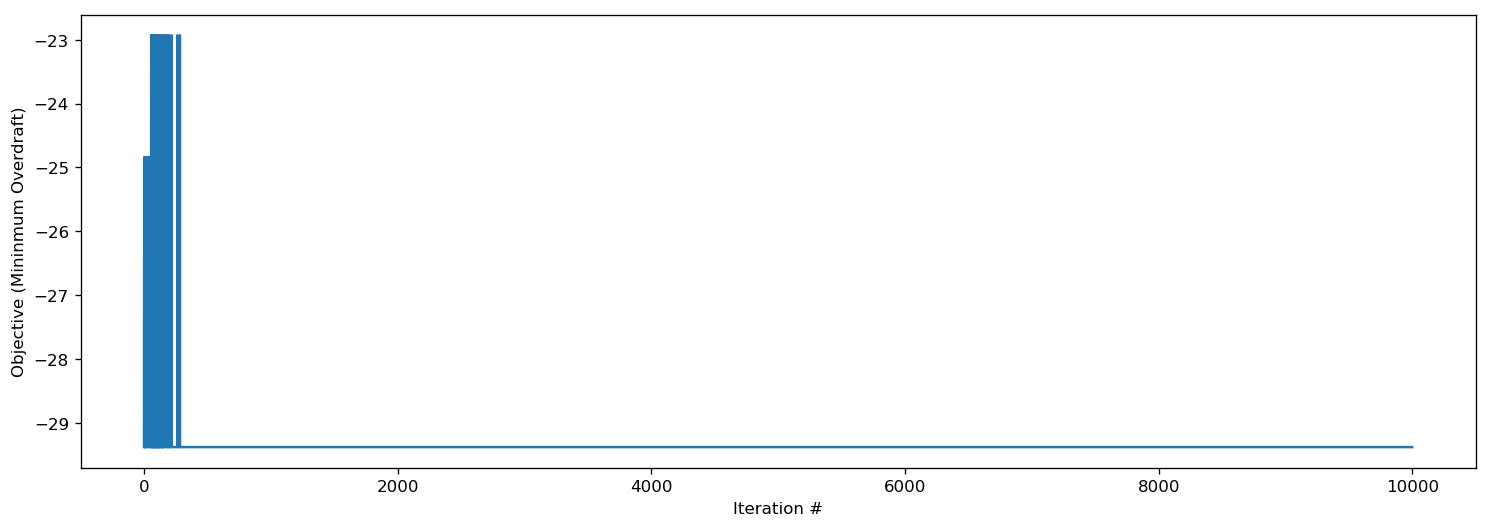

In [12]:
# The objective here is to reduce the negative overdraft
max_iterations = 10000
# initiate the lags
project.lags = np.timedelta64(0,"D")
project.os = project.es
project.of = project.ef
project.opt_cashin = project.cashin
project.opt_cashout = project.cashout
project.opt_overdraft = project.overdraft
best_overdraft = np.zeros(max_iterations) # Keep track of the best
tested_lags = [] # keep track of the tested lags
for iteration in range(max_iterations):
    p = copy.deepcopy(project)
    # Randomize the lags
    p.lags = [
        np.timedelta64(np.random.randint(0, int(p.tf[i]/np.timedelta64(1, 'D'))), "D") 
        if int(p.tf[i]/np.timedelta64(1, 'D')) > 0 else np.timedelta64(0, "D")
        for i in range(p.number_of_activities)
    ]
    # Do not repeat the same lags already tested 
    if p.lags in tested_lags:
        logging.info("Same lag tested! skipping iteration {}".format(iteration))
        best_overdraft[iteration] = p.overdraft.min()
        continue
    else:
        tested_lags.append(p.lags)
    # Initiate the the os and of
    p.os = p.es + p.lags
    p.of = p.os + p.dur
    # caculate the new schedule
    cond = True
    while cond:
        cond = False
        for i in range(project.number_of_activities):
            for pred in project.pred[i]:
                if p.os[i] < p.of[pred]:
                    p.os[i] = p.of[pred]
                    p.of[i] = p.os[i] + p.dur[i]
                    cond = True
    del cond
    # Calculate the new Cash flow
    project.opt_cashout = np.zeros(project.number_of_days)
    # Calculate the cashout
    for t in range(p.number_of_days):
        for i in range(p.number_of_activities):
            if p.time[t] > p.os[i] and p.time[t] <= p.of[i]:
                p.opt_cashout[t] += p.cost[i] / int(p.dur[i] / np.timedelta64(1, "D"))
    # Calculate the cashin
    p.opt_cashin = np.zeros(p.number_of_days)
    for t in range(p.number_of_days):
        if t > p.payment_days and str(p.time[t]).split("-")[2] == "01":
            p.opt_cashin[t] += (
                p.opt_cashout[0:t].sum()
                - p.opt_cashin[0:t].sum()
            )
    p.opt_cashin *= (1 + p.markup) * (1 - p.downpayment)
    p.opt_cashin[0] = p.cost.sum() * (1 + p.markup) * p.downpayment
    p.opt_cashin[p.number_of_days-1] = p.cost.sum() * (1 + p.markup) - p.cashin.sum()
    p.opt_overdraft = p.opt_cashin.cumsum() - p.opt_cashout.cumsum()
    # logging.info("{} -> {}".format(project.opt_overdraft.min(), p.opt_overdraft.min()))
    if p.opt_overdraft.min() > project.opt_overdraft.min():
        project = copy.deepcopy(p)
        logging.info("Found better solution at iteration {} from {} to {}".format(
            iteration,
            project.opt_overdraft.min(),
            p.opt_overdraft.min()
        ))
    if (iteration/max_iterations*100) % 5 == 0:
        logging.info("Done {}% @ Iteration {}".format(int(iteration/max_iterations*100), iteration))
    best_overdraft[iteration] = project.opt_overdraft.min()
logging.info("Done!")
plt.figure()
plt.plot(np.arange(max_iterations), best_overdraft)
plt.xlabel("Iteration #")
plt.ylabel("Objective (Mininmum Overdraft)")
plt.show()

### Draw Optimized Schedule

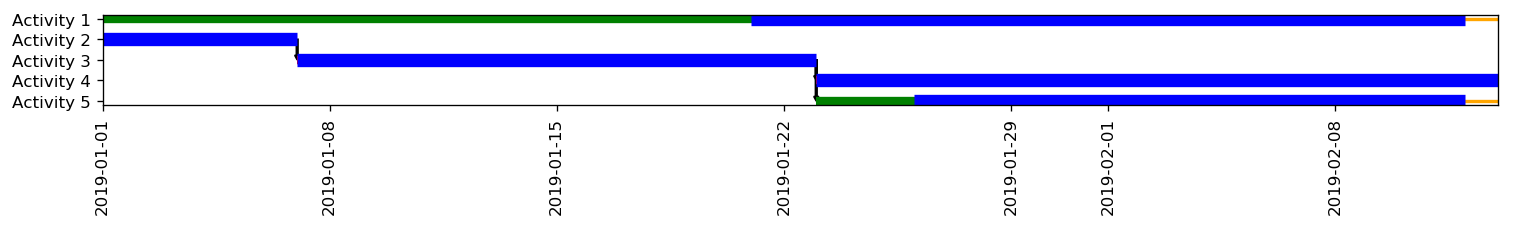

In [13]:
plt.figure(figsize=(15, int(project.number_of_activities / 3)))
# Draw Activities
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=project.es,
    xmax=project.ef,
    linewidth=5,
    color="green"
)
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=np.array([project.es[i] if project.es[i] == project.ls[i] else project.es[i] for i in range(project.number_of_activities)]),
    xmax=np.array([project.ef[i] if project.es[i] == project.ls[i] else project.es[i] for i in range(project.number_of_activities)]),
    linewidth=5,
    color="red"
)
# Draw Late
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=project.ef,
    xmax=project.lf,
    linewidth=2,
    color="orange"
)
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=project.os,
    xmax=project.of,
    linewidth=8,
    color="blue"
)
# Draw Arrow
for i in range(project.number_of_activities):
    for pred in project.pred[i]:
        plt.arrow(
            x=project.ef[pred],
            y=pred,
            dx=(project.ef[pred]-project.es[i]).astype('timedelta64[D]')/np.timedelta64(1,"D"),
            dy=i-pred,
            length_includes_head=True,
            width=0.05,
            color="black"
        )
plt.xlim(project.start, project.finish)
plt.xticks(rotation=90)
plt.gca().invert_yaxis()
plt.show()

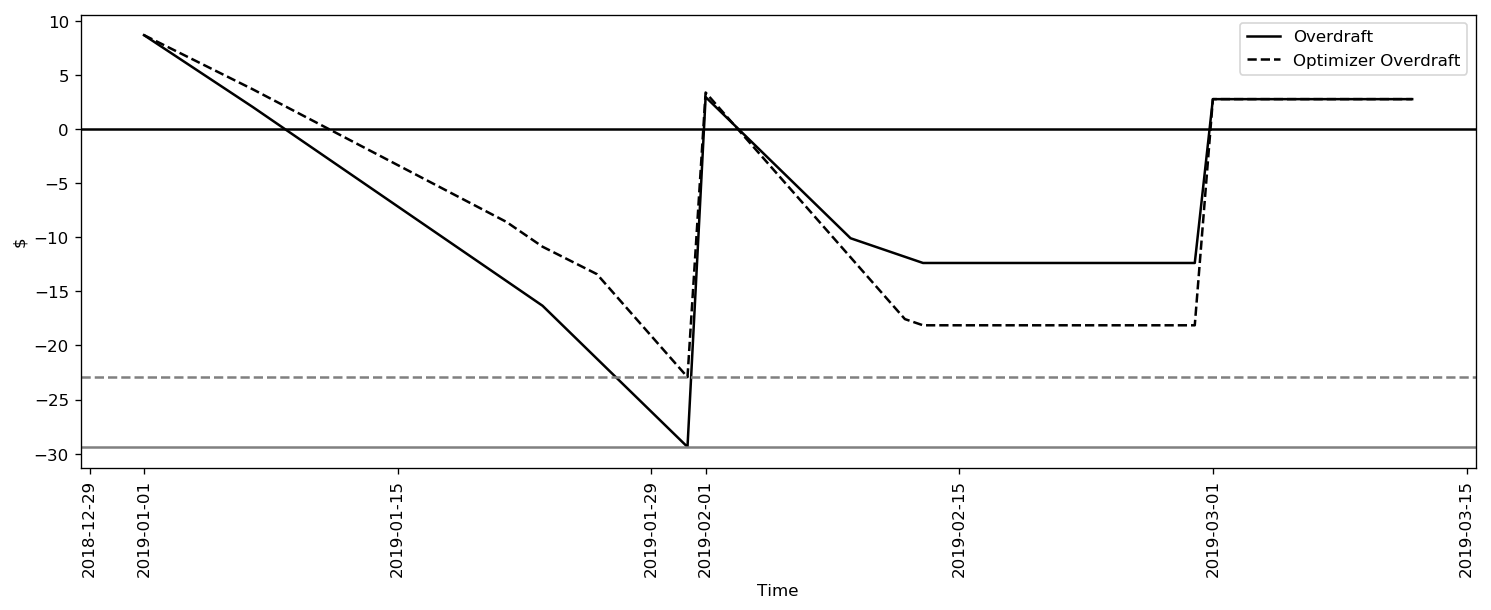

In [14]:
plt.figure()
plt.plot(project.time, project.overdraft, label="Overdraft", linestyle="-", color="k")
plt.plot(project.time, project.opt_overdraft, label="Optimizer Overdraft", linestyle="--", color="k")
plt.axhline(0, color="Black")
plt.axhline(project.overdraft.min(), color="grey", linestyle="-")
plt.axhline(project.opt_overdraft.min(), color="grey", linestyle="--")
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=1)
plt.show()

In [15]:
np.exp(project.interest * 0 / 365*20)

1.0

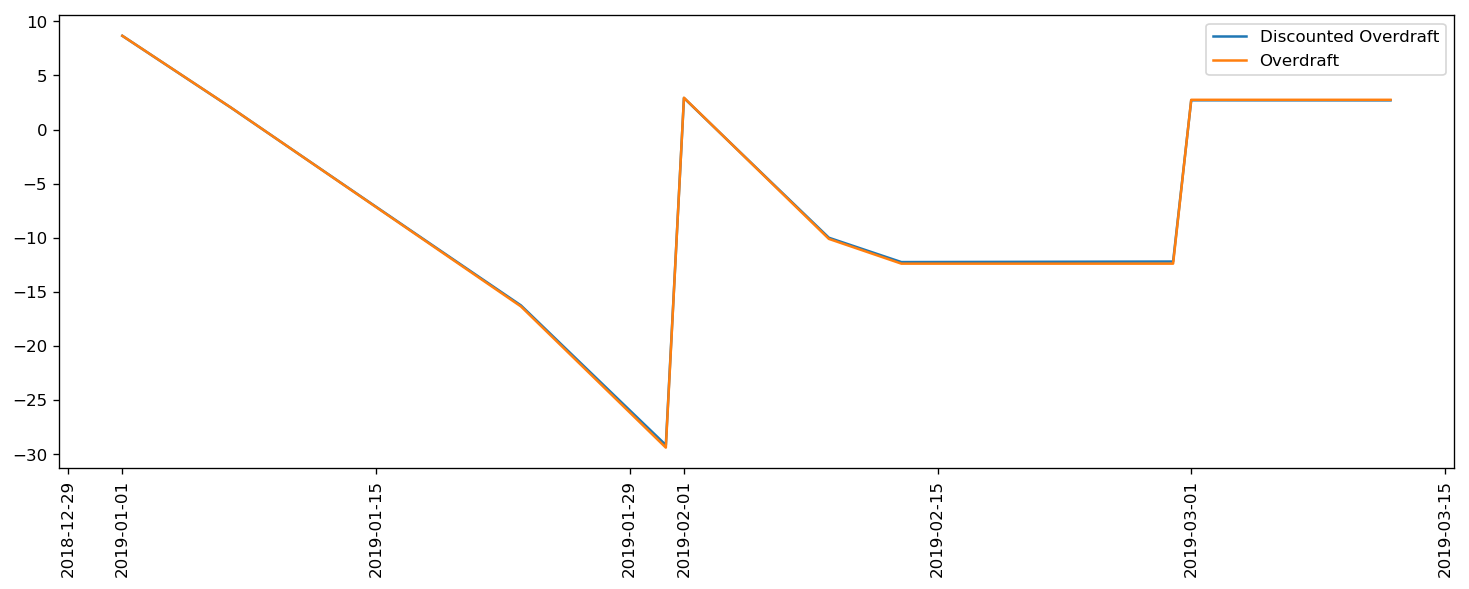

In [17]:
plt.plot(
    project.time,
    np.array(
        [
            project.overdraft[i] / np.exp(project.interest * i / 365)
            for i in range(project.number_of_days)
        ]
    ),
    label="Discounted Overdraft"
)
plt.plot(
    project.time, 
    project.overdraft,
    label="Overdraft"
)
plt.xticks(rotation=90)
plt.legend()
plt.show()